**Name:** Yara Elzahy

**ID:** 20398570

In [38]:
!pip install missingno

In [39]:
!pip install yellowbrick

In [40]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import seaborn as sns
from scipy import stats
import missingno as msno
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from scipy.stats import median_abs_deviation
from sklearn.preprocessing import LabelEncoder
# the following code ensures that you can print your results for multiple tasks within a coding block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**Q1** (10 points) Describe how you want to make use of merchants.csv, historical transactions.csv, and new merchant transactions.csv, for user loyalty prediction. Note, this is a very important question, you may want to update your whole pipeline multiple times to find the best usage of three files

In the 1st trial, we concatenate the historical_transactions table with the new_merchant_transactions table and then use the inner join on the card_id to merge the output table with the userscore table, and the output of the table of the join is then merged with the merchants table using the inner join as well on the common columns between them which are the merchant_id, city_id, state_id, category_1, category_2, merchant_category_id, subsector_id.

In the 2nd trial, we concatenate the historical_transactions table with the new_merchant_transactions table and then the output of the table of the join is then merged with the merchants table using the inner join as well on the common columns between them except for category_1 and category_2. After that we group the output table by the card_id and aggregate with the rest of the columns, then finally we use the inner join onto the card_id to merge it with the userscore table. This results in a  lot less number of records than the first trial, since each card_id exists only once in the table.

In [41]:
# read the historical transactions table from csv file
df_historical_transactions = pd.read_csv('historical_transactions.csv')
len(df_historical_transactions)   # print number of records
df_historical_transactions.head() # view top 5 records

29112361

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [42]:
# read the new merchant transactions table from csv file
df_new_merchant_transactions = pd.read_csv('new_merchant_transactions.csv')
len(df_new_merchant_transactions)   # print number of records
df_new_merchant_transactions.head() # view top 5 records

1963031

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [43]:
# concatenate the two csv files
df_combined_trans = pd.concat([df_historical_transactions, df_new_merchant_transactions], ignore_index=True)
# check they have been concatenated properly: check if the concatenated number of records is equal to the sum of records of the 2 previous tables
len(df_combined_trans) == (len(df_historical_transactions) + len(df_new_merchant_transactions))
df_combined_trans.head() # view top 5 records

True

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [44]:
# read the userscore table from csv file
df_userscore = pd.read_csv('userscore.csv')
df_userscore.head()  # view top 5 records

,card_id,first_active_month,feature_1,feature_2,feature_3,score
0,C_ID_92a2005557,Jun-17,5,2,1,-0.820283
1,C_ID_3d0044924f,Jan-17,4,1,0,0.392913
2,C_ID_d639edf6cd,Aug-16,2,2,0,0.688056
3,C_ID_186d6a6901,Sep-17,4,3,0,0.142495
4,C_ID_cdbd2c0db2,Nov-17,1,3,0,-0.159749


In [45]:
# read the merchants table from csv file
df_merchants = pd.read_csv('merchants.csv')
df_merchants.head()  # view top 5 records

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [46]:
df_userscore.columns

Index(['card_id', 'first_active_month', 'feature_1', 'feature_2', 'feature_3',
       'score'],
      dtype='object')

In [47]:
df_combined_trans.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

In [48]:
df_merchants.columns

Index(['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'numerical_1', 'numerical_2', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'city_id', 'state_id', 'category_2'],
      dtype='object')

**Q3** (10 points) Perform necessary data cleaning based on your answer to
Q2. As shown below.
1. first we print the percentage of missing values for each feature.
2. then we visualize missing values using the correlation analysis matrix, heatmap and dendogram to predict the pattern and mechanism of missing values.
3. after that we impute the missing values for category_2 and category_3 using the most frequent values.
4. Then we combine the avg_purchases_lag3, avg_purchases_lag6 and avg_purchases_lag12 columns into a new column called avg_purchases_lag since they have very high correlations between one another. 
5. then repeat step 4 for the active_months_lag3, active_months_lag6 and active_months_lag12 along with avg_sales_lag3, avg_sales_lag6 and avg_sales_lag12 columns.
6. finally drop the rest of the null values since their percentage is negligible
7. replace the installments column with values of -1 with 0, since it doesn't make sense as discussed below.

## Data Cleaning

### Statistical Analysis

### User-defined functions

In [49]:
# remove column outliers from data
def remove_outliers(data, column_name):
    column_data = data[column_name]

    # Calculate the z-scores for the column
    column_z_scores = (column_data - column_data.mean()) / column_data.std()

    # Set the threshold for outlier detection
    threshold = 1.5

    # Identify outliers
    outliers = column_z_scores.abs() > threshold

    # Remove outliers from the dataset
    data = data[~outliers]

    return data

Here we'll use a different approach to merge the tables together (using group by and aggregate functions).

In [50]:
df_combined_trans.head(2)

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16


In [51]:
df_merchants.head(2)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0


In [52]:
df_combined_trans.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id'],
      dtype='object')

In [53]:
df_merchants.columns

Index(['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'numerical_1', 'numerical_2', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12',
       'category_4', 'city_id', 'state_id', 'category_2'],
      dtype='object')

In [54]:
# merge the combined table and merchants table using the inner join on the merchant_id

columns_list = ['merchant_id', 'city_id', 'state_id', 'merchant_category_id', 'subsector_id']
df_combined_trans3 = df_combined_trans.merge(df_merchants, how='inner', on=columns_list)
len(df_combined_trans3)
df_combined_trans3.head(2)

20294539

,authorized_flag,card_id,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2_x,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,category_1_y,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,category_2_y
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,35,23.470597,23.014512,N,A,A,1.08,1.082451,3,1.14,1.114135,6,1.19,1.156844,12,Y,1.0
1,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,35,23.470597,23.014512,N,A,A,1.08,1.082451,3,1.14,1.114135,6,1.19,1.156844,12,Y,1.0


In [55]:
# check to see the columns of the final combined table
df_combined_trans3.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1_x', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2_x', 'state_id',
       'subsector_id', 'merchant_group_id', 'numerical_1', 'numerical_2',
       'category_1_y', 'most_recent_sales_range',
       'most_recent_purchases_range', 'avg_sales_lag3', 'avg_purchases_lag3',
       'active_months_lag3', 'avg_sales_lag6', 'avg_purchases_lag6',
       'active_months_lag6', 'avg_sales_lag12', 'avg_purchases_lag12',
       'active_months_lag12', 'category_4', 'category_2_y'],
      dtype='object')

In [56]:
df_combined_grp = df_combined_trans3.groupby('card_id')
df_combined_agg = df_combined_grp.agg({
   'authorized_flag': lambda x: x.mode()[0],
    'city_id': lambda x: x.mode()[0],
    'category_1_x':lambda x: x.mode()[0],
    'installments': 'mean',
    'category_3': lambda x: x.mode(),
    'merchant_category_id': lambda x: x.mode()[0],
    'merchant_id': lambda x: x.mode()[0],
    'month_lag': 'mean',
    'purchase_amount': 'mean',
    'purchase_date': 'max',
    'category_2_x':lambda x: x.mode(),
    'state_id': lambda x: x.mode()[0],
    'subsector_id': 'max',
    'merchant_group_id':'max',
    'numerical_1':'mean',
    'numerical_2':'mean',
    'category_1_y':lambda x: x.mode()[0],
    'most_recent_sales_range':lambda x: x.mode()[0],
    'most_recent_purchases_range':lambda x: x.mode()[0],
    'avg_sales_lag3':'mean',
    'avg_purchases_lag3':'mean',
    'active_months_lag3':'max',
    'avg_sales_lag6':'mean',
    'avg_purchases_lag6':'mean',
    'active_months_lag6':'max',
    'avg_sales_lag12':'mean',
    'avg_purchases_lag12': 'mean',
    'active_months_lag12': 'max',
    'category_4': lambda x: x.mode()[0],
    'category_2_y':'mean',
}
)
df_combined_agg.head(2)

,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2_x,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,category_1_y,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,category_2_y
card_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,Y,-1,Y,1.244444,B,755,M_ID_57df19bf28,-4.266667,-0.638961,2018-04-03 11:13:35,3.0,-1,34,71128,0.190402,0.157132,Y,A,A,0.994667,1.013273,3,0.992444,1.003570,6,0.970222,0.994065,12,Y,3.000000
C_ID_0001238066,Y,314,N,1.752137,B,307,M_ID_d17aabd756,-1.324786,-0.591449,2018-04-29 01:19:02,1.0,9,39,90722,9.879721,9.790741,N,C,C,1.028462,1.050330,3,1.047094,1.073136,6,1.079658,1.100800,12,N,1.424779


In [57]:
df_userscore.columns

Index(['card_id', 'first_active_month', 'feature_1', 'feature_2', 'feature_3',
       'score'],
      dtype='object')

In [58]:
df_combined_agg.columns

Index(['authorized_flag', 'city_id', 'category_1_x', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2_x', 'state_id',
       'subsector_id', 'merchant_group_id', 'numerical_1', 'numerical_2',
       'category_1_y', 'most_recent_sales_range',
       'most_recent_purchases_range', 'avg_sales_lag3', 'avg_purchases_lag3',
       'active_months_lag3', 'avg_sales_lag6', 'avg_purchases_lag6',
       'active_months_lag6', 'avg_sales_lag12', 'avg_purchases_lag12',
       'active_months_lag12', 'category_4', 'category_2_y'],
      dtype='object')

In [59]:
# merge the combined table and userscore table using the inner join on the card_id
df_grouped = df_combined_agg.merge(df_userscore, how='inner', on='card_id')
len(df_grouped)
df_grouped.head(2)

193627

,card_id,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2_x,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,category_1_y,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,category_2_y,first_active_month,feature_1,feature_2,feature_3,score
0,C_ID_00007093c1,Y,-1,Y,1.244444,B,755,M_ID_57df19bf28,-4.266667,-0.638961,2018-04-03 11:13:35,3.0,-1,34,71128,0.190402,0.157132,Y,A,A,0.994667,1.013273,3,0.992444,1.003570,6,0.970222,0.994065,12,Y,3.0,Feb-17,5,1,1,0.134077
1,C_ID_0001506ef0,Y,137,N,0.018182,A,705,M_ID_b1fc88154d,-4.254545,-0.492424,2018-03-22 09:14:30,3.0,19,37,98464,1.191807,1.028121,N,A,A,1.052909,1.072006,3,1.071636,1.094685,6,1.080909,1.115597,12,Y,3.0,Jul-16,2,2,0,0.884295


## Data Cleaning

### Statistical Analysis

#### 1) Percentage of missing data for each feature

In [60]:
# print the missing values
total_miss = df_grouped.isnull().sum()
percent_miss = (total_miss/df_grouped.isnull().count()*100)

# sort attributes by missing value ratio
missing_data = pd.DataFrame({'Total missing':total_miss,'% missing':percent_miss})
missing_data.sort_values(by='Total missing',ascending=False)

,Total missing,% missing
category_2_y,9604,4.960052
avg_sales_lag12,19,0.009813
avg_sales_lag3,19,0.009813
avg_sales_lag6,19,0.009813
card_id,0,0.000000
avg_purchases_lag3,0,0.000000
active_months_lag3,0,0.000000
avg_purchases_lag6,0,0.000000
active_months_lag6,0,0.000000
avg_purchases_lag12,0,0.000000


<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<AxesSubplot:>

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193627 entries, 0 to 193626
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   card_id                      193627 non-null  object 
 1   authorized_flag              193627 non-null  object 
 2   city_id                      193627 non-null  int64  
 3   category_1_x                 193627 non-null  object 
 4   installments                 193627 non-null  float64
 5   category_3                   193627 non-null  object 
 6   merchant_category_id         193627 non-null  int64  
 7   merchant_id                  193627 non-null  object 
 8   month_lag                    193627 non-null  float64
 9   purchase_amount              193627 non-null  float64
 10  purchase_date                193627 non-null  object 
 11  category_2_x                 193627 non-null  object 
 12  state_id                     193627 non-null  int64  
 13 

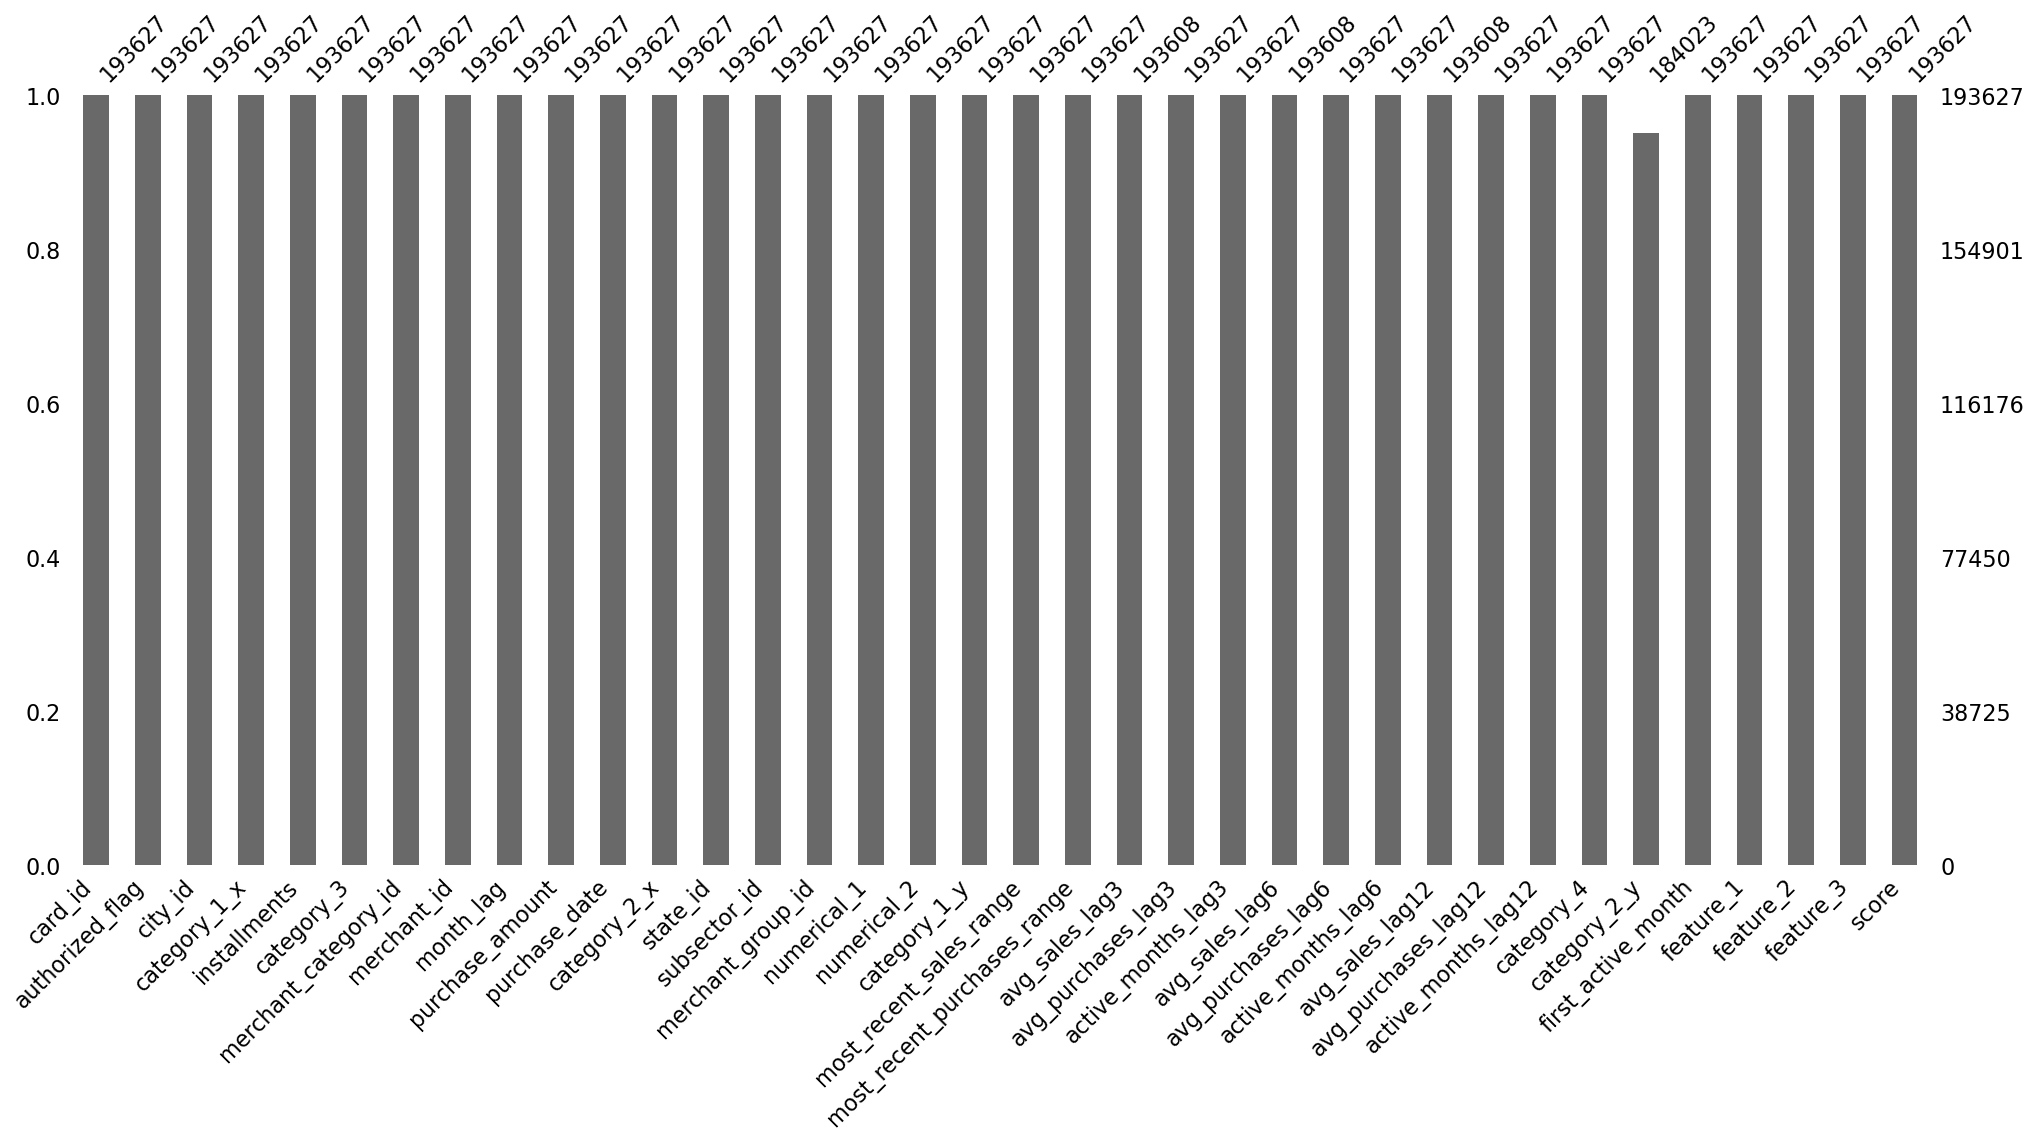

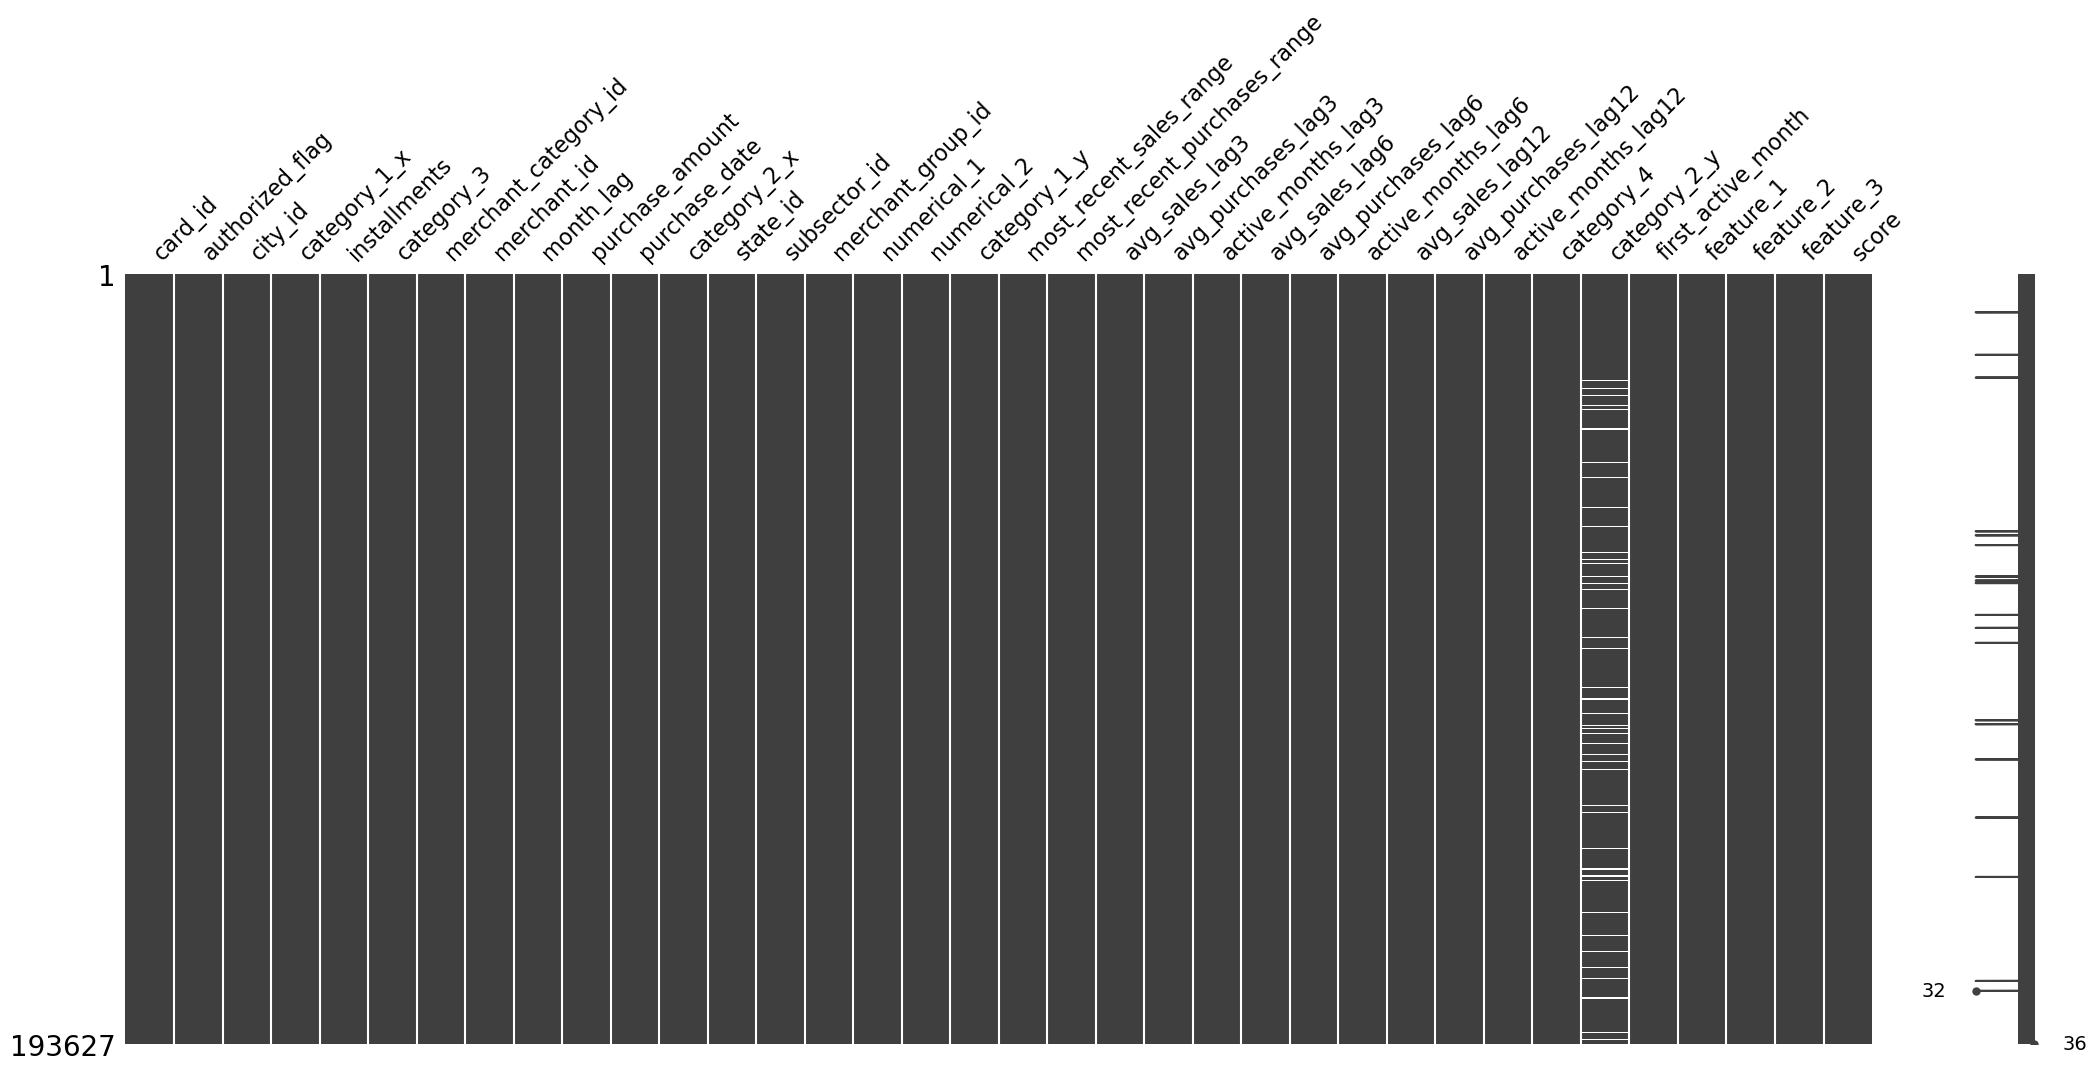

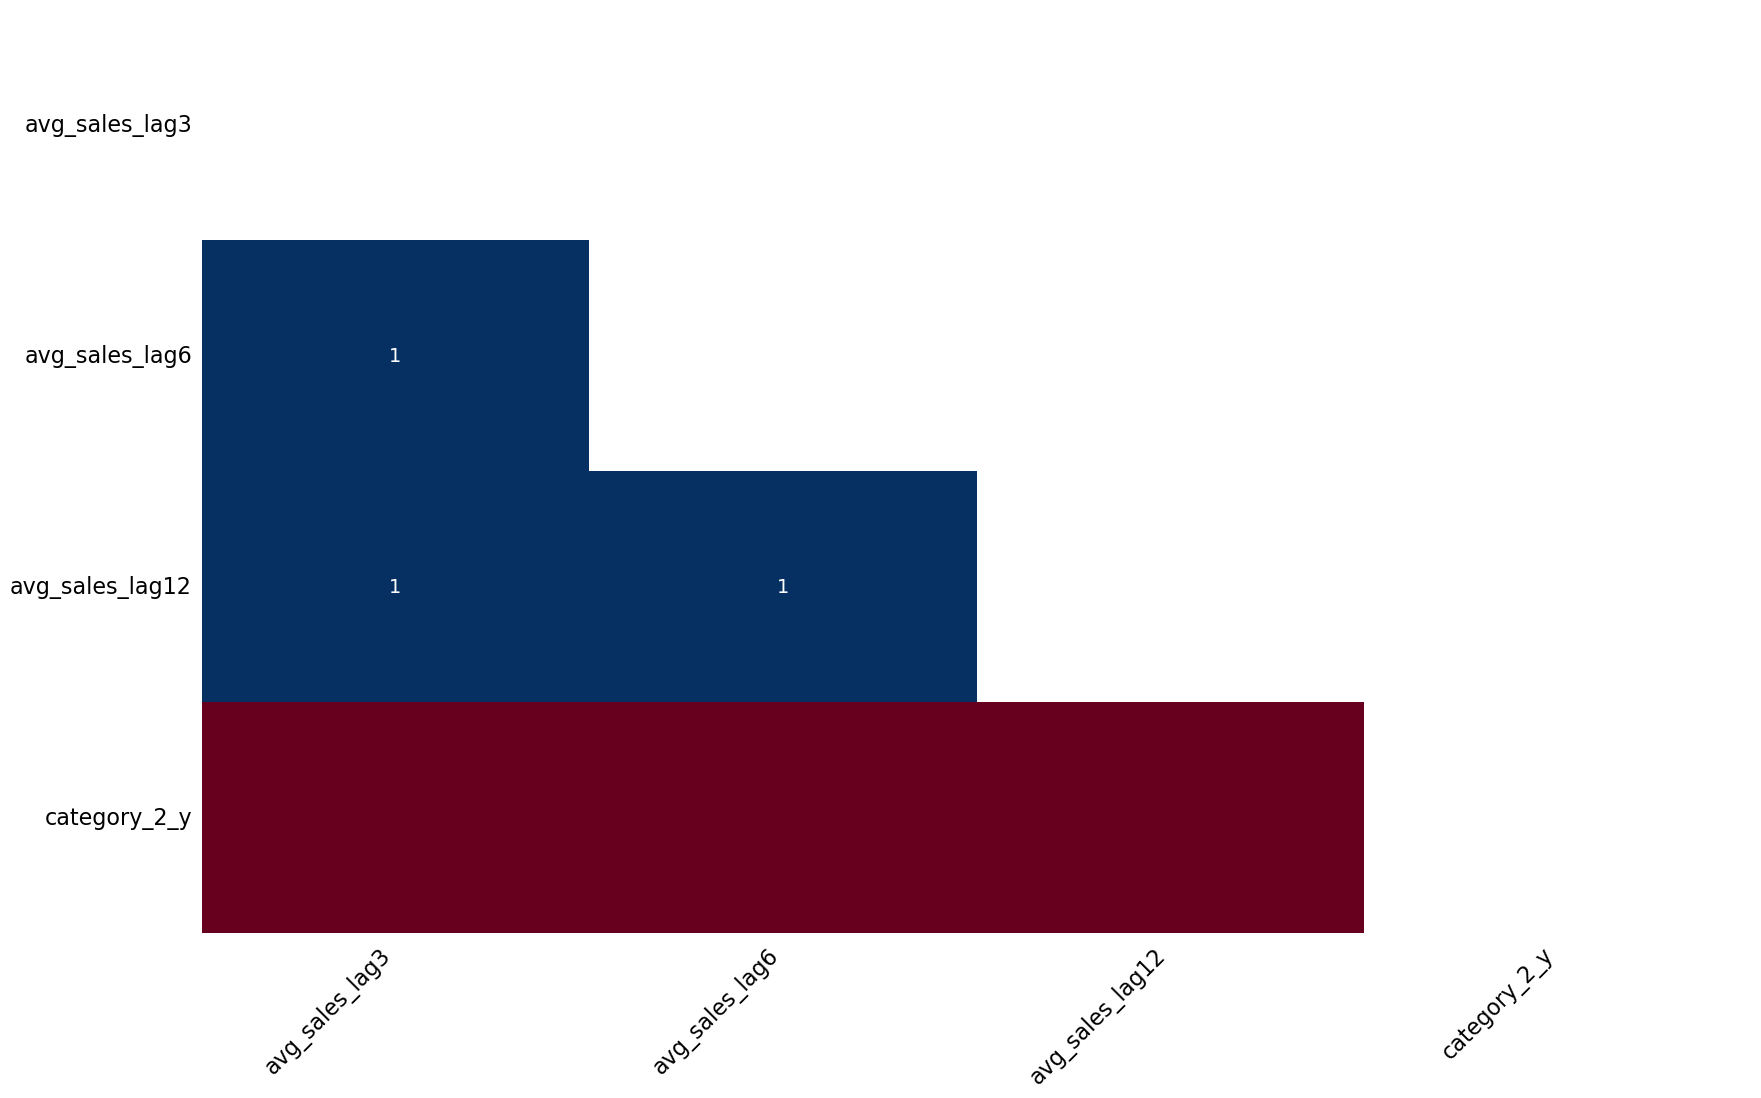

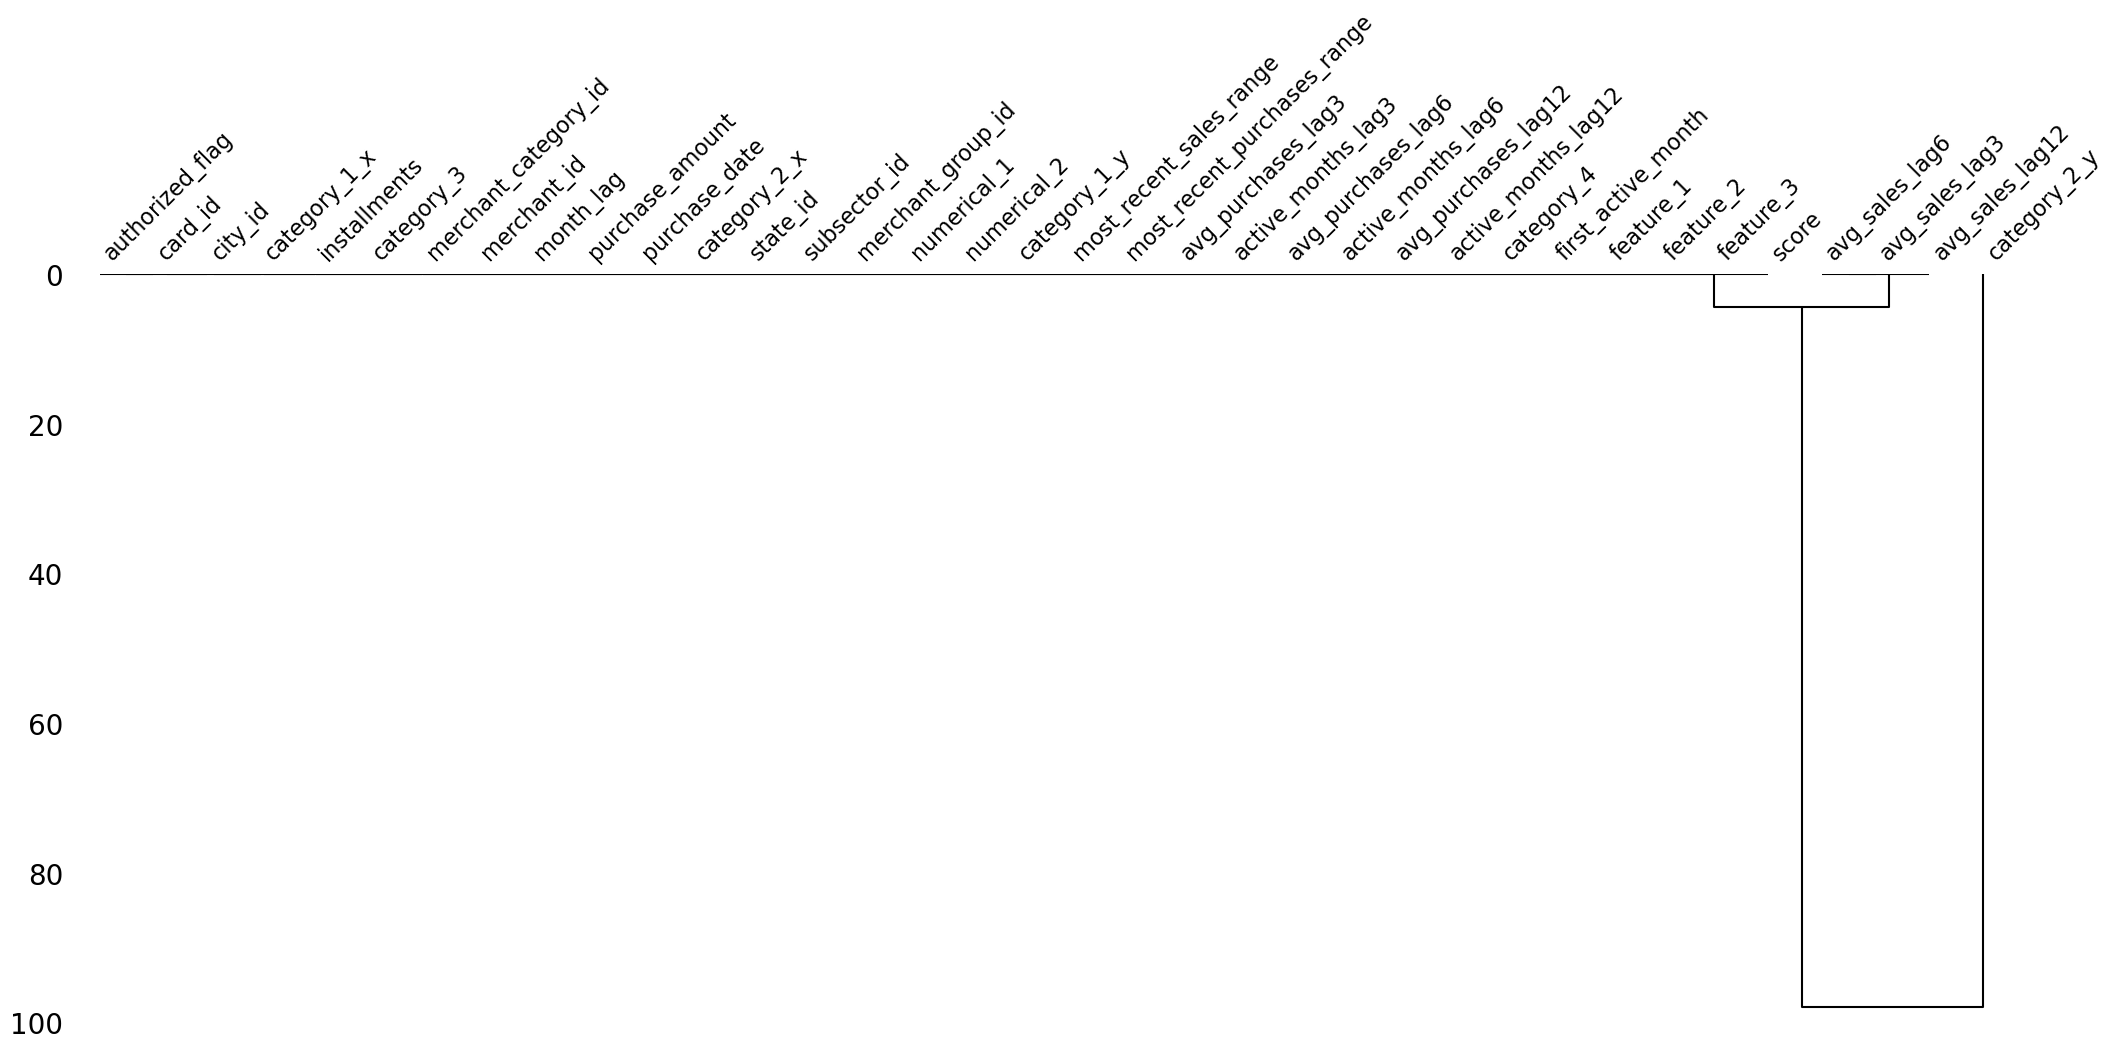

In [24]:
# visualize using msno package, no need in this case, just give for demo purpose.
msno.bar(df_grouped)

# visualize missing values as a matrix
msno.matrix(df_grouped)

# heatmap for correlation analysis
msno.heatmap(df_grouped)

# dendrogram plot
msno.dendrogram(df_grouped)

print(df_grouped.info())

The dataset has missing values in the category_2_y column (with 4.96%) and some missing values in the avg_sales_lag12, avg_sales_lag6 and avg_sales_lag3 columns (all with 0.0098%), which may affect the analysis of user behavior and transactions. The missing value pattern followed by category_2_y seem to be random, and the missing value mechanism is assumed to be missing at random **(MCAR)** since it's not dependant on any other feature. While the other remaining columns, including the avg_sales_lag12, avg_sales_lag6 and avg_sales_lag3 columns appear to follow **MAR** since they're highly correlated with one another.

In [25]:
df_grouped.shape

(193627, 36)

In [26]:
df_grouped['category_2_x'].value_counts()

1.0           101378
3.0            31362
5.0            25890
4.0            17407
2.0             7145
               ...  
[]                 1
[]                 1
[]                 1
[]                 1
[1.0, 4.0]         1
Name: category_2_x, Length: 10450, dtype: int64

In [27]:
df_grouped['category_2_y'].unique()

array([3.        , 1.        ,        nan, ..., 1.03351955, 1.12413793,
       3.77931034])

In [28]:
df_grouped['category_2_y'].value_counts()

1.000000    87304
3.000000    23008
5.000000    18039
4.000000    10130
2.000000     4915
            ...  
3.113861        1
3.992857        1
4.941748        1
4.858521        1
3.779310        1
Name: category_2_y, Length: 11305, dtype: int64

In [29]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193627 entries, 0 to 193626
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   card_id                      193627 non-null  object 
 1   authorized_flag              193627 non-null  object 
 2   city_id                      193627 non-null  int64  
 3   category_1_x                 193627 non-null  object 
 4   installments                 193627 non-null  float64
 5   category_3                   193627 non-null  object 
 6   merchant_category_id         193627 non-null  int64  
 7   merchant_id                  193627 non-null  object 
 8   month_lag                    193627 non-null  float64
 9   purchase_amount              193627 non-null  float64
 10  purchase_date                193627 non-null  object 
 11  category_2_x                 193627 non-null  object 
 12  state_id                     193627 non-null  int64  
 13 

In [30]:
df_grouped['avg_sales_lag12'].unique()

array([0.97022222, 1.08090909, 1.10388889, ..., 0.77647399, 1.15924528,
       1.42146341])

In [31]:
df_grouped['avg_sales_lag12'].isnull().sum()
df_grouped['avg_sales_lag12'].value_counts()

19

0.560000    794
1.030000    750
0.740000    463
0.970000    435
1.040000    392
           ... 
0.877692      1
1.172600      1
4.227308      1
1.753553      1
1.421463      1
Name: avg_sales_lag12, Length: 96899, dtype: int64

#### Missing Data Imputation

In [61]:
# replace NAN category 2 with the mode (most repeated values)
df_grouped['category_2_y'] = df_grouped['category_2_y'].fillna(df_grouped['category_2_y'].mode()[0])
df_grouped['avg_sales_lag12'] = df_grouped['avg_sales_lag12'].fillna(df_grouped['avg_sales_lag12'].mean())
df_grouped['avg_sales_lag6'] = df_grouped['avg_sales_lag6'].fillna(df_grouped['avg_sales_lag6'].mean())
df_grouped['avg_sales_lag3'] = df_grouped['avg_sales_lag3'].fillna(df_grouped['avg_sales_lag3'].mean())

In [62]:
# check whether we have other null values
df_grouped.isnull().sum().sum()

0

#### 2) Descriptive statistics for all features

In [34]:
df_grouped.describe(include="all")

,card_id,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,category_2_y,first_active_month,feature_1,feature_2,feature_3,score
count,193627,193627,193627.000000,193627,193627.000000,193627,193627.000000,193627,193627.000000,193627.000000,...,193627.000000,1.936270e+05,193627.000000,193627,193627.000000,193627,193627.000000,193627.00000,193627.000000,193627.000000
unique,193627,2,NaN,2,NaN,2756,NaN,43854,NaN,NaN,...,NaN,NaN,NaN,2,NaN,75,NaN,NaN,NaN,NaN
top,C_ID_00007093c1,Y,NaN,N,NaN,B,NaN,M_ID_e5374dabc0,NaN,NaN,...,NaN,NaN,NaN,Y,NaN,Sep-17,NaN,NaN,NaN,NaN
freq,1,187977,NaN,174745,NaN,89669,NaN,6196,NaN,NaN,...,NaN,NaN,NaN,104302,NaN,13276,NaN,NaN,NaN,NaN
mean,NaN,NaN,120.905318,NaN,0.887553,NaN,479.173411,NaN,-3.379871,1.964242,...,147.085328,inf,11.986324,NaN,2.165506,NaN,3.110062,1.74000,0.562654,-0.402163
std,NaN,NaN,98.823672,NaN,1.325118,NaN,240.692798,NaN,2.406102,911.326261,...,5853.037493,NaN,0.224488,NaN,1.460458,NaN,1.194042,0.75193,0.496060,3.853792
min,NaN,NaN,-1.000000,NaN,-1.000000,NaN,2.000000,NaN,-13.000000,-0.746893,...,0.170000,1.420103e-01,2.000000,NaN,1.000000,NaN,1.000000,1.00000,0.000000,-33.219281
25%,NaN,NaN,34.000000,NaN,0.000000,NaN,307.000000,NaN,-5.173913,-0.682819,...,1.015000,1.030863e+00,12.000000,NaN,1.000000,NaN,2.000000,1.00000,0.000000,-0.885669
50%,NaN,NaN,88.000000,NaN,1.000000,NaN,506.000000,NaN,-3.058442,-0.624845,...,1.089667,1.098632e+00,12.000000,NaN,1.000000,NaN,3.000000,2.00000,1.000000,-0.029359
75%,NaN,NaN,191.000000,NaN,1.303030,NaN,705.000000,NaN,-1.456416,-0.501671,...,1.199350,1.215017e+00,12.000000,NaN,3.000000,NaN,4.000000,2.00000,1.000000,0.754276


In [35]:
df_grouped.installments.value_counts()

0.000000    57135
1.000000    14070
2.000000     1698
1.500000     1320
1.333333     1011
            ...  
0.246032        1
1.450495        1
1.145907        1
0.009324        1
1.040462        1
Name: installments, Length: 15419, dtype: int64

In [63]:
# installments cannot have a negative value, so we'll replace it with 0
df_grouped['installments'] = df_grouped['installments'].replace(-1, 0)
df_grouped.installments.value_counts()

0.000000    57248
1.000000    14070
2.000000     1698
1.500000     1320
1.333333     1011
            ...  
1.276699        1
1.460938        1
0.995283        1
0.808511        1
1.040462        1
Name: installments, Length: 15418, dtype: int64

In [37]:
df_grouped.installments.unique()

array([1.24444444e+00, 1.81818182e-02, 1.84126984e+00, ...,
       2.94117647e-03, 4.52631579e+00, 1.04046243e+00])

#### 3) Loyalty Score Histogram

(array([2.1240e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.0000e+00, 1.0000e+00, 6.0000e+00, 6.0000e+00, 7.0000e+00,
        4.0000e+00, 1.3000e+01, 2.6000e+01, 4.9000e+01, 1.3200e+02,
        2.4300e+02, 6.5000e+02, 1.4290e+03, 2.9400e+03, 6.4010e+03,
        1.5514e+04, 3.9250e+04, 6.7122e+04, 3.4374e+04, 1.3049e+04,
        5.6250e+03, 2.4830e+03, 1.1890e+03, 5.6800e+02, 2.4300e+02,
        7.9000e+01, 4.3000e+01, 2.1000e+01, 1.2000e+01, 6.0000e+00,
        6.0000e+00, 1.0000e+00, 4.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([-33.21928095, -32.19559396, -31.17190698, -30.14821999,
        -29.124533  , -28.10084601, -27.07715903, -26.05347204,
        -25.02978505, -24.00609807, -22.98241108, -21.95872409,
        -20.93503711, -19.91135012, -18.88766313, -17.86397614,
        -16.84028916, -15.81660217, -14.79291518, -13.7692282 

Text(0.5, 1.0, 'Histogram of Loyalty Score')

Text(0.5, 0, 'Loyalty Score')

Text(0, 0.5, 'Frequency')

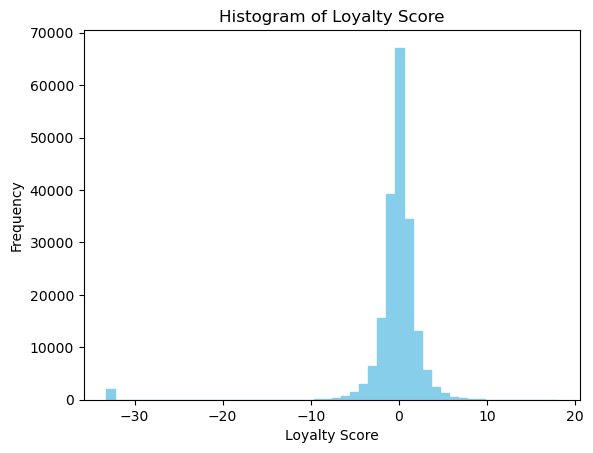

In [38]:
# Create a histogram of the loyalty score to give visual representation of the distribution of the score.
plt.hist(df_grouped['score'], bins=50, color = "skyblue", ec="skyblue")
plt.title('Histogram of Loyalty Score')
plt.xlabel('Loyalty Score')
plt.ylabel('Frequency')
plt.show()

### Perform Label Encoding
So that we're able to see the correlations between all features not just the numerical ones, so we'll convert categorical features to label encoding.

In [112]:
df_grouped.dtypes

card_id                         object
authorized_flag                 object
city_id                          int64
category_1_x                    object
installments                   float64
category_3                      object
merchant_category_id             int64
merchant_id                     object
month_lag                      float64
purchase_amount                float64
purchase_date                   object
category_2_x                    object
state_id                         int64
subsector_id                     int64
merchant_group_id                int64
numerical_1                    float64
numerical_2                    float64
category_1_y                    object
most_recent_sales_range         object
most_recent_purchases_range     object
avg_sales_lag3                 float64
avg_purchases_lag3             float64
active_months_lag3               int64
avg_sales_lag6                 float64
avg_purchases_lag6             float64
active_months_lag6       

In [65]:
# store all categorical and object values into the categorical_columns variable
categorical_columns = list(df_grouped.select_dtypes(include=['object']))

# define label encoder
label_enc = LabelEncoder()

df4 = df_grouped.copy()

df5 = df4.apply(lambda col: label_enc.fit_transform(col.astype(str)), axis=0, result_type='expand')

# convert each categorical column into label encoding
# for column in categorical_columns:
#     df4[column] = label_enc.fit_transform(df4[column])
df5.head(2)

,card_id,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2_x,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,category_1_y,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,category_2_y,first_active_month,feature_1,feature_2,feature_3,score
0,0,1,0,1,8509,1,208,17925,20309,94692,109595,2,0,26,19706,42602,37957,1,0,0,10521,41682,1,13363,32179,3,11828,27575,2,1,6211,24,4,0,1,105816
1,1,1,34,0,1341,0,199,32567,20243,35311,93537,2,11,29,31487,96217,89708,0,0,0,34709,122429,1,36991,110741,3,34669,103528,2,1,6211,36,1,1,0,146234


#### 4) Matrix Correlation

<AxesSubplot:>

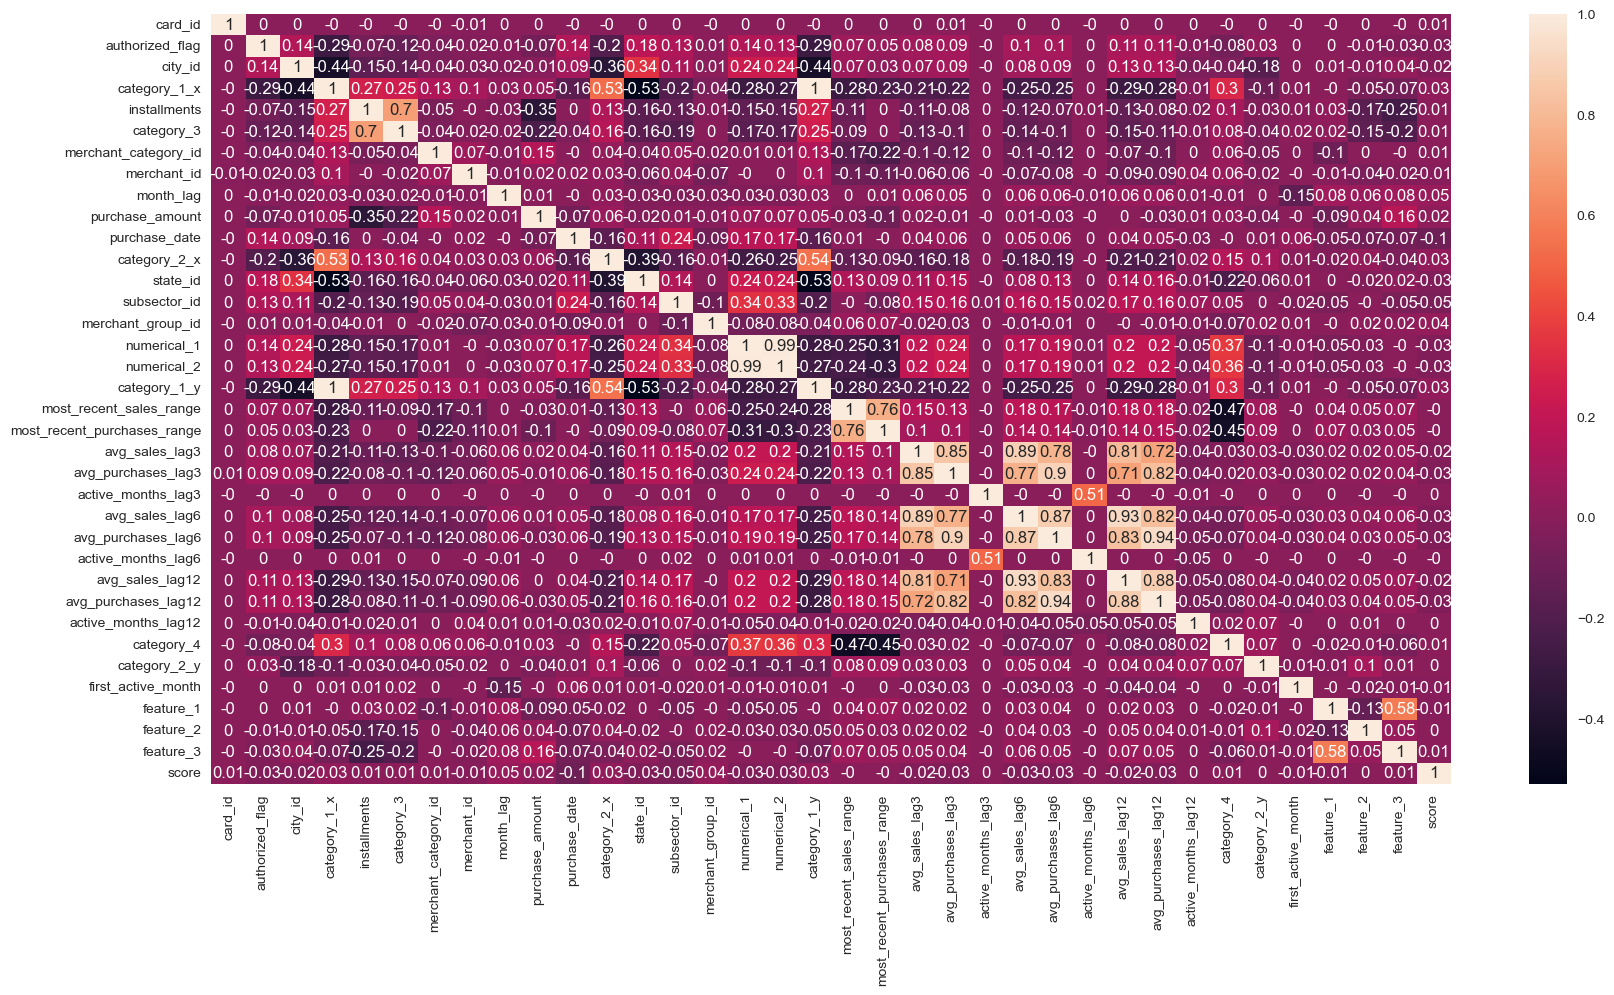

In [114]:
fig, ax = plt.subplots(figsize=(20, 10))
corr = df5.corr(method = "pearson").round(2)
sns.heatmap(corr, annot=True)

In [115]:
df5.corr(method = "pearson").round(2).style.background_gradient(cmap="rainbow")

,card_id,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2_x,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,category_1_y,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,category_2_y,first_active_month,feature_1,feature_2,feature_3,score
card_id,1.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.010000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.010000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.010000
authorized_flag,0.000000,1.000000,0.140000,-0.290000,-0.070000,-0.120000,-0.040000,-0.020000,-0.010000,-0.070000,0.140000,-0.200000,0.180000,0.130000,0.010000,0.140000,0.130000,-0.290000,0.070000,0.050000,0.080000,0.090000,-0.000000,0.100000,0.100000,0.000000,0.110000,0.110000,-0.010000,-0.080000,0.030000,0.000000,0.000000,-0.010000,-0.030000,-0.030000
city_id,0.000000,0.140000,1.000000,-0.440000,-0.150000,-0.140000,-0.040000,-0.030000,-0.020000,-0.010000,0.090000,-0.360000,0.340000,0.110000,0.010000,0.240000,0.240000,-0.440000,0.070000,0.030000,0.070000,0.090000,-0.000000,0.080000,0.090000,0.000000,0.130000,0.130000,-0.040000,-0.040000,-0.180000,0.000000,0.010000,-0.010000,0.040000,-0.020000
category_1_x,-0.000000,-0.290000,-0.440000,1.000000,0.270000,0.250000,0.130000,0.100000,0.030000,0.050000,-0.160000,0.530000,-0.530000,-0.200000,-0.040000,-0.280000,-0.270000,1.000000,-0.280000,-0.230000,-0.210000,-0.220000,0.000000,-0.250000,-0.250000,0.000000,-0.290000,-0.280000,-0.010000,0.300000,-0.100000,0.010000,-0.000000,-0.050000,-0.070000,0.030000
installments,-0.000000,-0.070000,-0.150000,0.270000,1.000000,0.700000,-0.050000,-0.000000,-0.030000,-0.350000,0.000000,0.130000,-0.160000,-0.130000,-0.010000,-0.150000,-0.150000,0.270000,-0.110000,0.000000,-0.110000,-0.080000,0.000000,-0.120000,-0.070000,0.010000,-0.130000,-0.080000,-0.020000,0.100000,-0.030000,0.010000,0.030000,-0.170000,-0.250000,0.010000
category_3,-0.000000,-0.120000,-0.140000,0.250000,0.700000,1.000000,-0.040000,-0.020000,-0.020000,-0.220000,-0.040000,0.160000,-0.160000,-0.190000,0.000000,-0.170000,-0.170000,0.250000,-0.090000,0.000000,-0.130000,-0.100000,0.000000,-0.140000,-0.100000,0.000000,-0.150000,-0.110000,-0.010000,0.080000,-0.040000,0.020000,0.020000,-0.150000,-0.200000,0.010000
merchant_category_id,-0.000000,-0.040000,-0.040000,0.130000,-0.050000,-0.040000,1.000000,0.070000,-0.010000,0.150000,-0.000000,0.040000,-0.040000,0.050000,-0.020000,0.010000,0.010000,0.130000,-0.170000,-0.220000,-0.100000,-0.120000,0.000000,-0.100000,-0.120000,0.000000,-0.070000,-0.100000,0.000000,0.060000,-0.050000,0.000000,-0.100000,0.000000,-0.000000,0.010000
merchant_id,-0.010000,-0.020000,-0.030000,0.100000,-0.000000,-0.020000,0.070000,1.000000,-0.010000,0.020000,0.020000,0.030000,-0.060000,0.040000,-0.070000,-0.000000,0.000000,0.100000,-0.100000,-0.110000,-0.060000,-0.060000,-0.000000,-0.070000,-0.080000,-0.000000,-0.090000,-0.090000,0.040000,0.060000,-0.020000,-0.000000,-0.010000,-0.040000,-0.020000,-0.010000
month_lag,0.000000,-0.010000,-0.020000,0.030000,-0.030000,-0.020000,-0.010000,-0.010000,1.000000,0.010000,-0.000000,0.030000,-0.030000,-0.030000,-0.030000,-0.030000,-0.030000,0.030000,0.000000,0.010000,0.060000,0.050000,0.000000,0.060000,0.060000,-0.010000,0.060000,0.060000,0.010000,-0.010000,0.000000,-0.150000,0.080000,0.060000,0.080000,0.050000
purchase_amount,0.000000,-0.070000,-0.010000,0.050000,-0.350000,-0.220000,0.150000,0.020000,0.010000,1.000000,-0.070000,0.060000,-0.020000,0.010000,-0.010000,0.070000,0.070000,0.050000,-0.030000,-0.100000,0.020000,-0.010000,-0.000000,0.010000,-0.030000,-0.000000,0.000000,-

<AxesSubplot:>

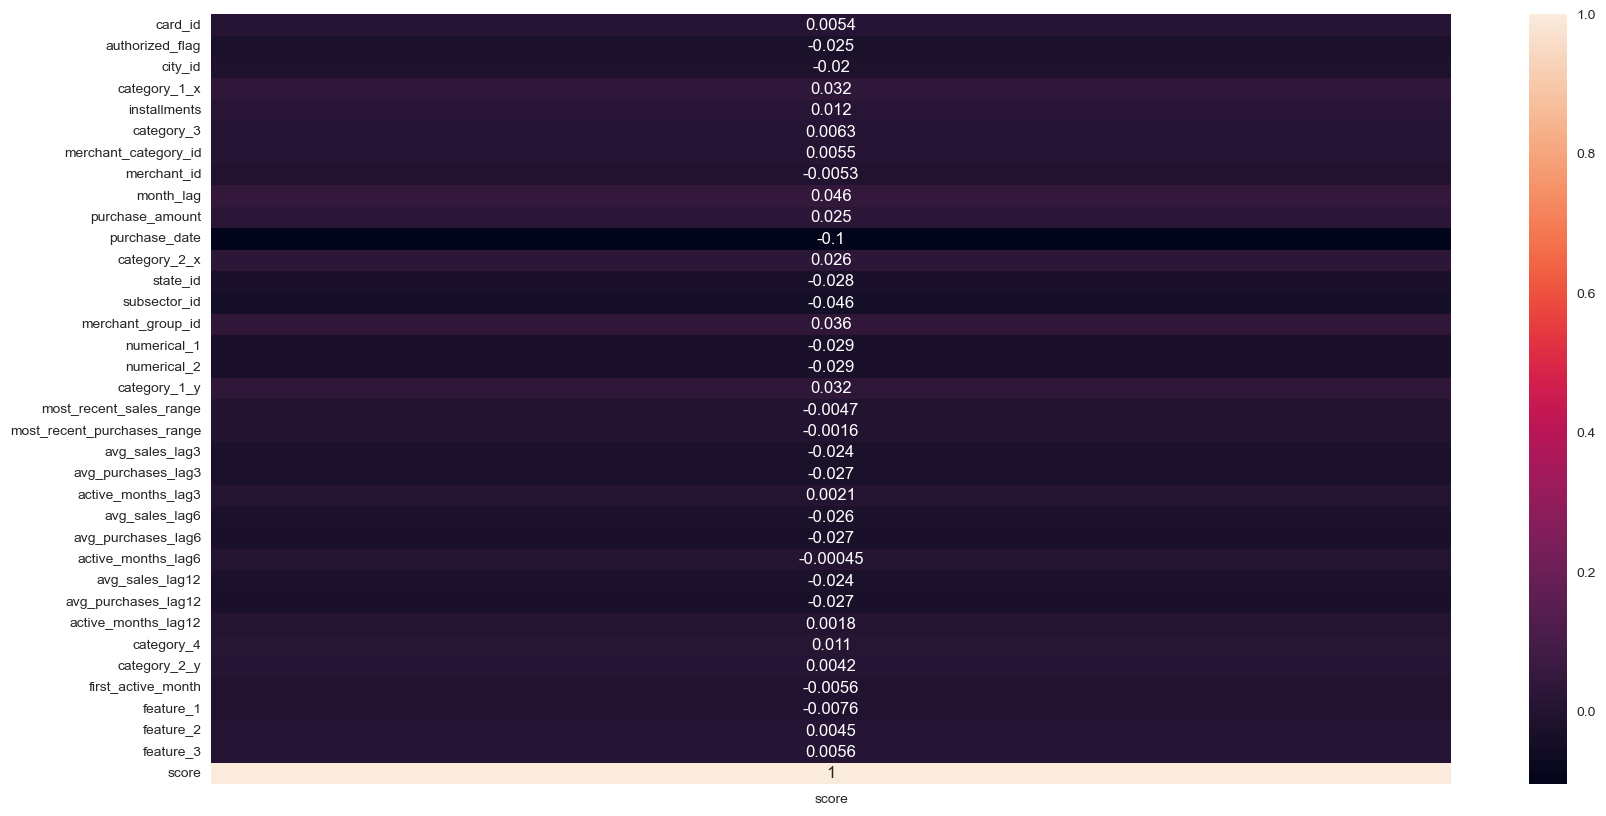

In [116]:
fig, ax = plt.subplots(figsize=(20, 10))
corr = df5.corr()[['score']]
sns.heatmap(corr, annot=True)

In [117]:
# Calculate the correlation coefficients between the loyalty score and all other features
correlations = df5.corr()['score'].drop('score')

# Print the correlation coefficients in descending order
print(correlations.sort_values(ascending=False))

month_lag                      0.046197
merchant_group_id              0.036270
category_1_y                   0.032441
category_1_x                   0.032311
category_2_x                   0.026458
purchase_amount                0.024671
installments                   0.012380
category_4                     0.011371
category_3                     0.006303
feature_3                      0.005621
merchant_category_id           0.005458
card_id                        0.005405
feature_2                      0.004532
category_2_y                   0.004160
active_months_lag3             0.002080
active_months_lag12            0.001752
active_months_lag6            -0.000449
most_recent_purchases_range   -0.001595
most_recent_sales_range       -0.004744
merchant_id                   -0.005277
first_active_month            -0.005644
feature_1                     -0.007640
city_id                       -0.019775
avg_sales_lag12               -0.023644
avg_sales_lag3                -0.024087


Since the avg_purchases_lag3, avg_purchases_lag6 and avg_purchases_lag12 have very high correlations between one another. Same applies for the active_months_lag3, active_months_lag6 and active_months_lag12 along with avg_sales_lag3, avg_sales_lag6 and avg_sales_lag12.

In [66]:
col1 = ["avg_purchases_lag3","avg_purchases_lag6","avg_purchases_lag12"]
# where "avg_purchases_lag3" is the start column name and "avg_purchases_lag12" is the end column name

df5['avg_purchases_lag'] = df5[col1].mean(axis=1)
df_grouped['avg_purchases_lag'] = df_grouped[col1].mean(axis=1)
df5.head(2)

,card_id,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2_x,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,category_1_y,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,category_2_y,first_active_month,feature_1,feature_2,feature_3,score,avg_purchases_lag
0,0,1,0,1,8509,1,208,17925,20309,94692,109595,2,0,26,19706,42602,37957,1,0,0,10521,41682,1,13363,32179,3,11828,27575,2,1,6211,24,4,0,1,105816,33812.000000
1,1,1,34,0,1341,0,199,32567,20243,35311,93537,2,11,29,31487,96217,89708,0,0,0,34709,122429,1,36991,110741,3,34669,103528,2,1,6211,36,1,1,0,146234,112232.666667


In [67]:
col2 = ["active_months_lag3","active_months_lag6","active_months_lag12"]
# where "avg_purchases_lag3" is the start column name and "avg_purchases_lag12" is the end column name

df5['active_months_lag'] = df5[col2].mean(axis=1)
df_grouped['active_months_lag'] = df_grouped[col2].mean(axis=1)

col3 = ["avg_sales_lag3","avg_sales_lag6","avg_sales_lag12"]
# where "avg_purchases_lag3" is the start column name and "avg_purchases_lag12" is the end column name

df5['avg_sales_lag'] = df5[col3].mean(axis=1)
df_grouped['avg_sales_lag'] = df_grouped[col3].mean(axis=1)

df5.head(2)

,card_id,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2_x,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,category_1_y,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,category_2_y,first_active_month,feature_1,feature_2,feature_3,score,avg_purchases_lag,active_months_lag,avg_sales_lag
0,0,1,0,1,8509,1,208,17925,20309,94692,109595,2,0,26,19706,42602,37957,1,0,0,10521,41682,1,13363,32179,3,11828,27575,2,1,6211,24,4,0,1,105816,33812.000000,2.0,11904.000000
1,1,1,34,0,1341,0,199,32567,20243,35311,93537,2,11,29,31487,96217,89708,0,0,0,34709,122429,1,36991,110741,3,34669,103528,2,1,6211,36,1,1,0,146234,112232.666667,2.0,35456.333333


In [68]:
cols = col1 + col2 + col3
cols

['avg_purchases_lag3',
 'avg_purchases_lag6',
 'avg_purchases_lag12',
 'active_months_lag3',
 'active_months_lag6',
 'active_months_lag12',
 'avg_sales_lag3',
 'avg_sales_lag6',
 'avg_sales_lag12']

In [69]:
df5.drop(cols, axis='columns', inplace=True)
df_grouped.drop(cols, axis='columns', inplace=True)

In [122]:
df5.head(2)

,card_id,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,category_4,category_2_y,first_active_month,feature_1,feature_2,feature_3,score,avg_purchases_lag,active_months_lag,avg_sales_lag
0,0,1,0,1,8509,1,208,17925,20309,94692,...,1,6211,24,4,0,1,105816,33812.000000,2.0,11904.000000
1,1,1,34,0,1341,0,199,32567,20243,35311,...,1,6211,36,1,1,0,146234,112232.666667,2.0,35456.333333


In [70]:
# The most_recent_purchases_range  and the most_recent_sales_range columns have extremely high correlation 
# they are also identical to one another, so we'll remove one of them
# the same applies for the purchase_date and the month_lag columns
df5.drop(columns=['most_recent_sales_range', 'purchase_date'], axis='columns', inplace=True)
df_grouped.drop(columns=['most_recent_sales_range', 'purchase_date'], axis='columns', inplace=True)

In [71]:
# The avg_purchases_lag  and the avg_sales_lag columns have extremely high correlation 
# they are also identical to one another, so we'll remove one of them
df5.drop(columns=['avg_sales_lag'], axis='columns', inplace=True)
df_grouped.drop(columns=['avg_sales_lag'], axis='columns', inplace=True)

#### 5) Mean and standard deviation of the loyalty score

In [25]:
# Calculate the mean and standard deviation of the loyalty score
loyalty_score_mean = np.mean(df5['score'])
loyalty_score_std = np.std(df5['score'])

# Print the mean and standard deviation of the loyalty score
print('Mean loyalty score: {:.2f}'.format(loyalty_score_mean))
print('Standard deviation of loyalty score: {:.2f}'.format(loyalty_score_std))

Mean loyalty score: 94583.55
Standard deviation of loyalty score: 54073.88


**Q2** (20 points) Discuss the quality of the dataset, considering missing values, missing value patterns, missing value mechanism, and noise (e.g., consistency). Note, you do not need to discuss each attribute in each table. Focus on the ones you believe are the most important for user (card) loyalty analysis and prediction.

The dataset has missing values in the category_2 and category_3 columns as well (with 9.446% and 0.695% respectively). and some missing values in the avg_sales_lag12, avg_sales_lag6 and avg_sales_lag3 columns (all with 0.0462%), which may affect the analysis of user behavior and transactions. The missing value pattern followed by category_2 nd category_3 seem to be random, and the missing value mechanism is assumed to be missing at random **(MCAR)** since they're not dependant on any other feature. While the other remaining columns, including the avg_sales_lag12, avg_sales_lag6 and avg_sales_lag3 columns appear to follow **MAR** since they're highly correlated with one another. The dataset also has some noise, such as inconsistent formatting of dates and negative values in some columns (installements column) that may require further cleaning and preprocessing before analysis. 

The installments contain values of -1, which doesn't make sense and should be replaced with a value of 0 to remive the noise.
Also, the data contains outliers shown a few scrolls below, so we'll remove those that are considered as noise and leave the ones that could not be considered as noise.

category_2 and category_3 columns with NA values have been imputed below with the most frequent values and the other NA values have been dropped since they represent a negligible percentage missing data.

The missing values in the dataset appear to follow a **general pattern**, since there is no clear pattern of missing values in the dataset, and the missing values are randomly distributed across the rows and columns. Therefore, it is unlikely that the missing values are due to a specific missing data mechanism, such as univariate pattern, unit non-response pattern, planned missing pattern, latent variable pattern, or monotone missing pattern. Instead, the missing values seem to occur randomly or due to other factors that are not related to the data itself.

The most important features or columns in the final combined dataset for user (card) loyalty analysis and prediction are:

**card_id**: This column is the unique identifier for each user and is essential for tracking user transactions and behavior.

**purchase_amount**: This column represents the amount of each transaction and is important for analyzing user spending behavior.

**category_1**: This column indicates whether the transaction was made in a high-risk category and can provide insights into user risk behavior.

**category_2** and **category_3**: These columns represent the merchant category and subcategory, respectively, and can provide insights into user preferences for different types of merchants and products.

**state_id** and **city_id**: These columns represent the state and city where the transaction was made, respectively, and can provide insights into user location-based behavior and preferences.

**month_lag**: This column represents the number of months between the transaction date and the reference date and can provide insights into user behavior over time.

These columns can be used to extract various features and insights related to user behavior and loyalty, which can be used to predict user loyalty to different merchants.

**Q4** (10 points) Report important statistics in preprocessed data created
in Q3. The target user loyalty score must be covered in the statistical
analysis.

**1) Percentage of missing data for each feature**: reporting the percentage of missing data for each feature in the dataset can help identify any data quality issues that may affect the analysis of data.
The dataset has missing values in the category_2 and category_3 columns as well (with 9.446% and 0.695% respectively), and some missing values in the avg_sales_lag12, avg_sales_lag6 and avg_sales_lag3 columns (all with 0.0462%), which may affect the analysis of user behavior and transactions.

**2) Descriptive statistics for all features**: reporting mean, standard deviation, minimum, maximum, quartiles, and other descriptive statistics for other important features in the dataset that may affect the loyalty score. This can give an idea of the distribution and variability of these features in your dataset.
Some insights from the above descriptive statistics:
* The variable card_id has 193,600 unique values, with "C_ID_0cd2ce025c" being the most frequent value (appearing 2,548 times).
* The variable city_id has a mean value of 122.6281 and a standard deviation of 95.98936. The minimum value is -1 and the maximum value is 347.
* The variable installments has a mean value of 0.6382884 and a standard deviation of 2.516409. The minimum value is -1 and the maximum value is 999.
* The variable month_lag has a mean value of -4.137123 and a standard deviation of 3.773048. The minimum value is -13 and the maximum value is 2.
* The variable purchase_amount has a mean value of 0.2455403 and a standard deviation of 1701.561. The minimum value is -0.7469078 and the maximum value is 6,010,604.

**3) Loyalty Score Histogram**: This can give a visual representation of the distribution of the target variable in the dataset.
* The histogram is skewed to the right, indicating that the majority of loyalty scores are clustered towards the left side of the distribution.
* The most frequent loyalty scores are between approximately -10 and 10, with a peak around 0.
* There are a few outlier loyalty scores on the far left side of the distribution, with scores below -30.
* The majority of loyalty scores appear to be between approximately -20 and 20.

**4) Correlation Matrix**: This can show the correlation coefficients between the loyalty score and all other features in the dataset, which can help you identify which features are most strongly related to the target variable.
The are some columns with have extremely high correlation, this includes:
* The avg_purchases_lag  and the avg_sales_lag columns with correlation of 0.95
* The most_recent_purchases_range  and the most_recent_sales_range columns with correlation of 0.9
* The purchase_date and the month_lag columns with correlation of 0.86

so we'll drop one of the pairs of columns with a high correlation to prevent our model from overfitting.

**5) Mean and standard deviation of the loyalty score**: 
* Mean loyalty score: -0.46
* Standard deviation of loyalty score: 3.61

#### Check if data contains outliers:

{'whiskers': [<matplotlib.lines.Line2D at 0x22399c32070>,
 'caps': [<matplotlib.lines.Line2D at 0x22399c32610>,
 'boxes': [<matplotlib.lines.Line2D at 0x22399ca1d60>],
 'medians': [<matplotlib.lines.Line2D at 0x22399c32bb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22399c32e80>],
 'means': []}

Text(0.5, 0, 'month_lag')

Text(0.5, 1.0, 'Boxplot of Data with Outliers')

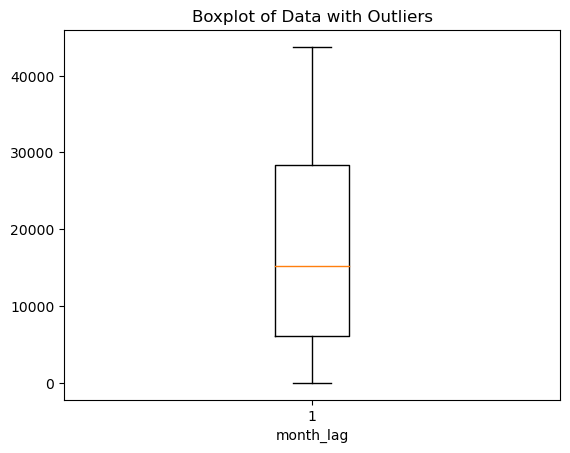

In [54]:
# Create a boxplot of the dataset
plt.boxplot(df5['month_lag'], vert=True, showfliers=True)

# Add labels and title to the plot
plt.xlabel('month_lag')
plt.title('Boxplot of Data with Outliers')

# Display the plot
plt.show()

array([20309, 20243,  9020, ..., 31951, 32495, 22409])

<AxesSubplot:xlabel='month_lag', ylabel='score'>

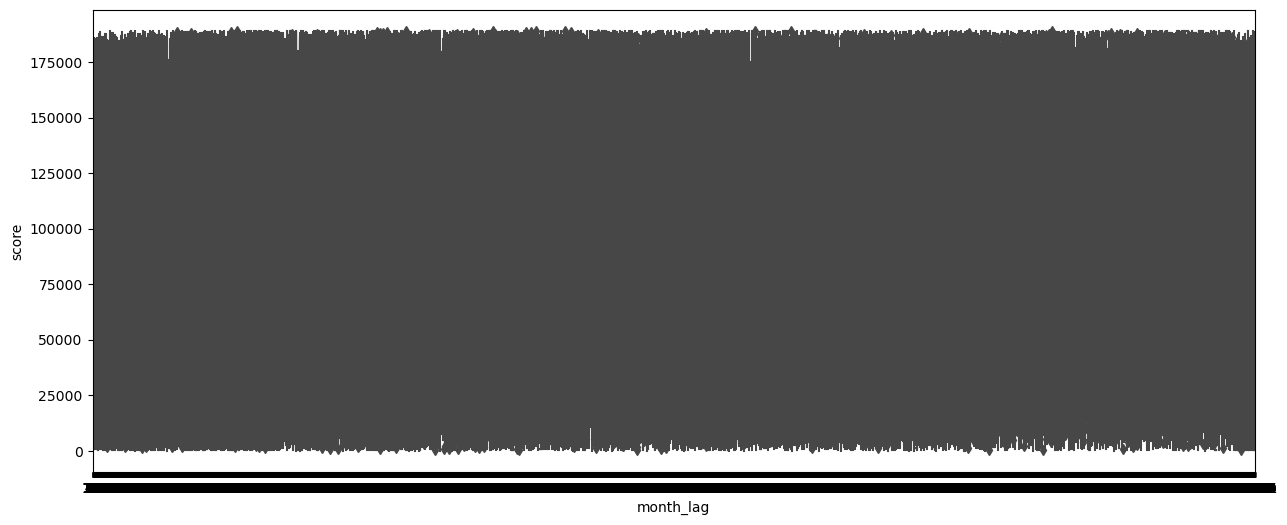

In [55]:
#check month_lag
df5['month_lag'].unique()

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='month_lag',y='score',data=df5,palette='rainbow')

In [26]:
# Set the threshold for outlier detection
threshold = 1.5

# Calculate the z-scores for each feature
z_scores = (df5 - df5.mean()) / df5.std()

# Identify outliers
outliers = z_scores.abs() > threshold

# Count the number of outliers for each feature
num_outliers = outliers.sum()

# Print the number of outliers for each feature
print(num_outliers.sort_values(ascending=False))

feature_1                      51418
feature_2                      36111
most_recent_purchases_range    29863
avg_purchases_lag              28835
score                          26997
state_id                       26119
card_id                        25940
purchase_amount                25515
merchant_group_id              25503
merchant_id                    23955
category_2_y                   23867
installments                   23261
month_lag                      22699
category_1_y                   18908
category_1_x                   18882
numerical_2                    17835
numerical_1                    17081
subsector_id                   16864
category_3                     14408
first_active_month             12345
category_2_x                   10354
merchant_category_id            6239
authorized_flag                 5650
city_id                         2219
active_months_lag                818
feature_3                          0
category_4                         0
d

In [26]:
df5['most_recent_purchases_range'].unique()

array([0, 2, 3, 1, 4])

<AxesSubplot:xlabel='most_recent_purchases_range', ylabel='score'>

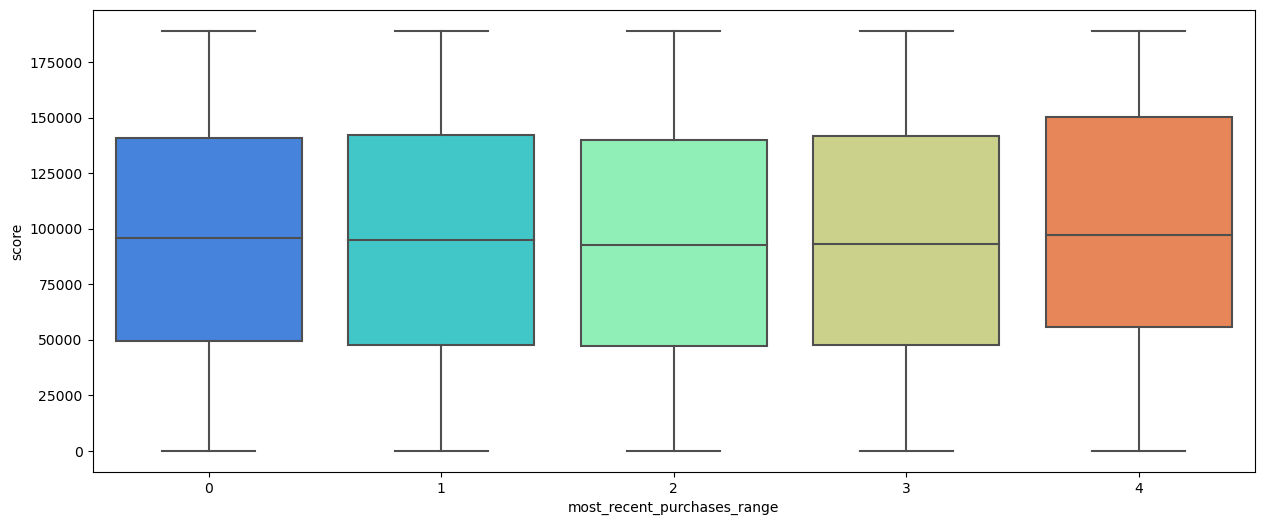

In [58]:
# check category_1

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='most_recent_purchases_range',y='score',data=df5,palette='rainbow')

In [59]:
df5['avg_purchases_lag'].unique() # too many values, so we won't plot the boxplot

array([ 33812.        , 112232.66666667,  80979.33333333, ...,
       163364.66666667,  25982.66666667,  16525.33333333])

<AxesSubplot:xlabel='avg_purchases_lag', ylabel='score'>

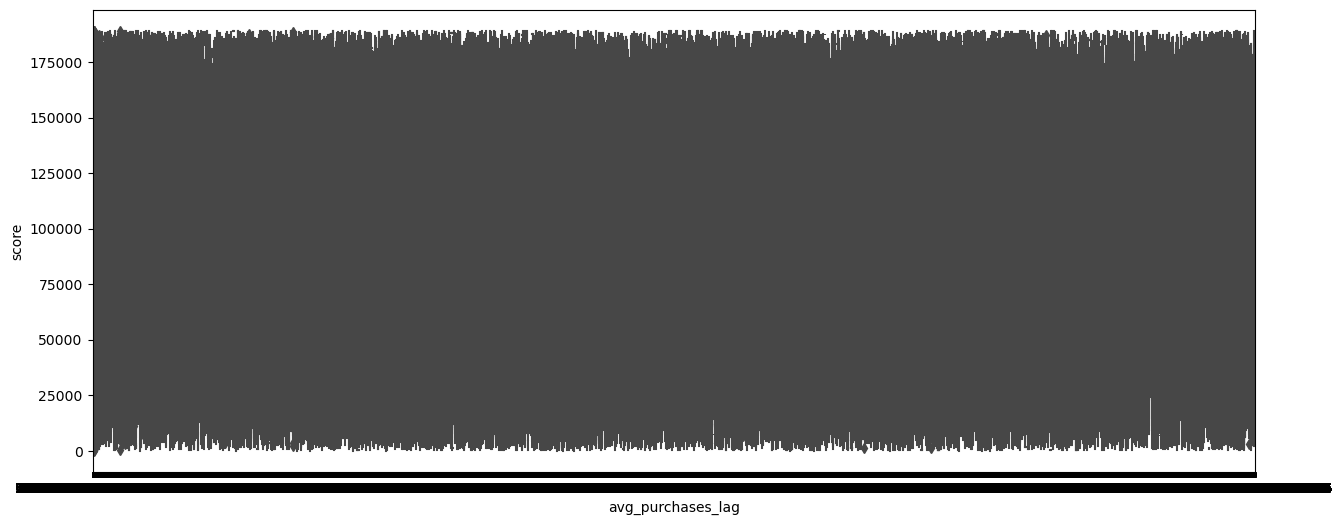

In [60]:
# check category_2

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='avg_purchases_lag',y='score',data=df5,palette='rainbow')

array([6211,    0, 5609, ...,  644, 1565, 7618])

<AxesSubplot:xlabel='category_2_y', ylabel='score'>

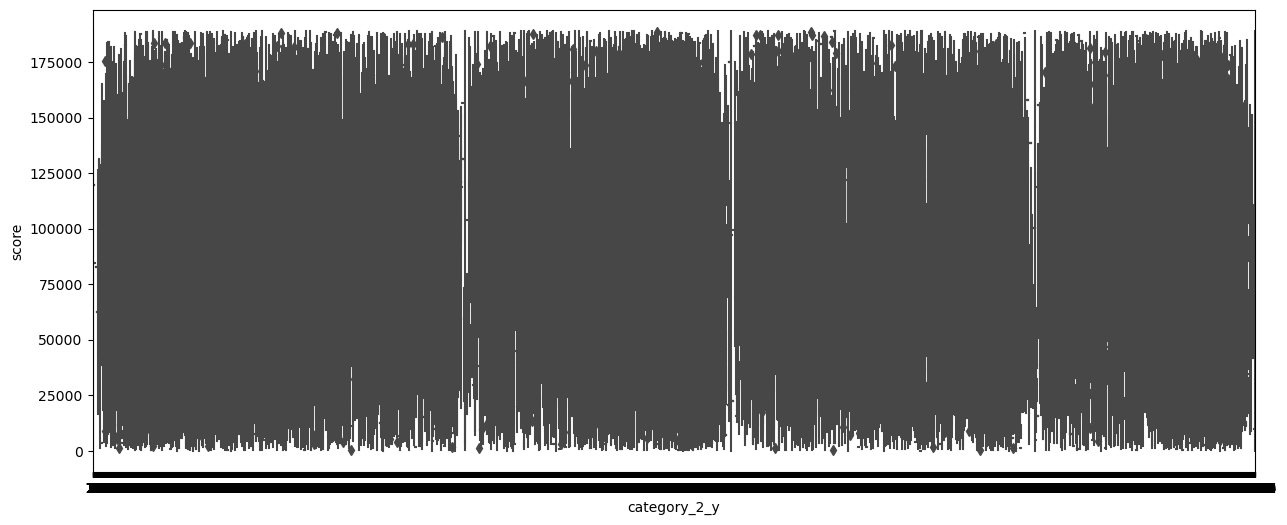

In [61]:
# check category_3
df5['category_2_y'].unique()

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='category_2_y',y='score',data=df5,palette='rainbow')

array([4, 1, 3, 2, 0])

<AxesSubplot:xlabel='feature_1', ylabel='score'>

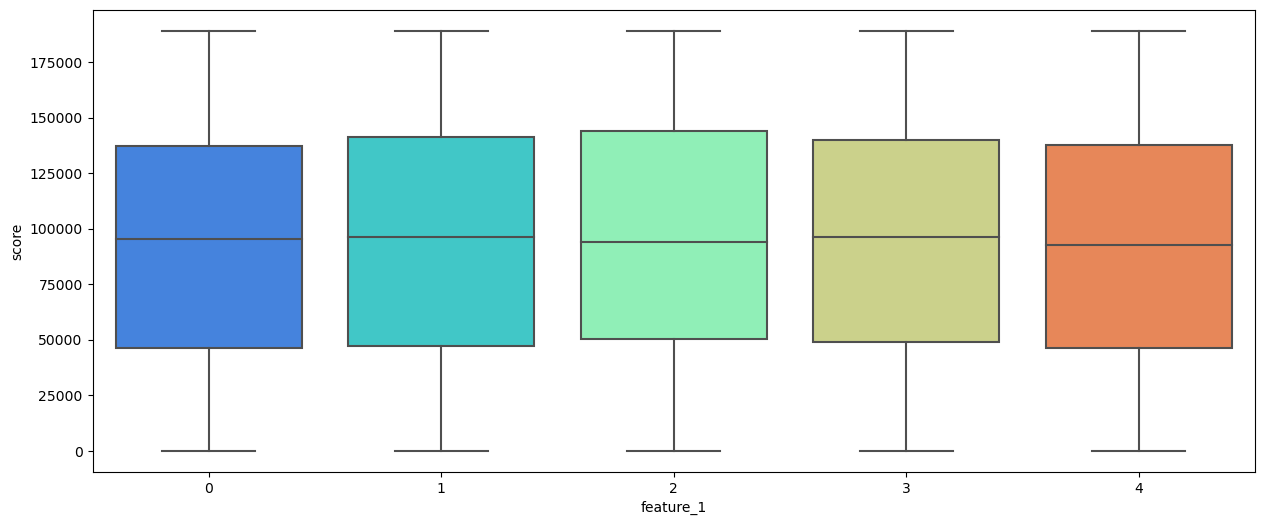

In [62]:
# check feature_1
df5['feature_1'].unique()

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='feature_1',y='score',data=df5,palette='rainbow')

array([0, 1, 2])

<AxesSubplot:xlabel='feature_2', ylabel='score'>

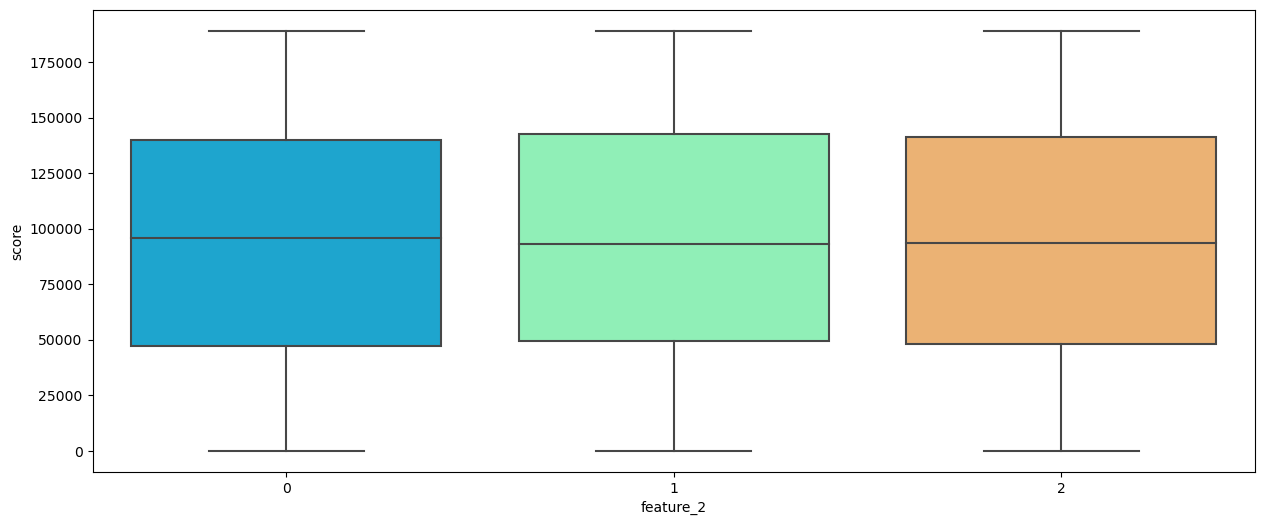

In [63]:
# check feature_2
df5['feature_2'].unique()

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='feature_2',y='score',data=df5,palette='rainbow')

{'whiskers': [<matplotlib.lines.Line2D at 0x22c37e98c10>,
 'caps': [<matplotlib.lines.Line2D at 0x22c37eab1f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x22c37e98940>],
 'medians': [<matplotlib.lines.Line2D at 0x22c37eab790>],
 'fliers': [<matplotlib.lines.Line2D at 0x22c37eaba60>],
 'means': []}

Text(0.5, 0, 'purchase_amount')

Text(0.5, 1.0, 'Boxplot of Data with Outliers')

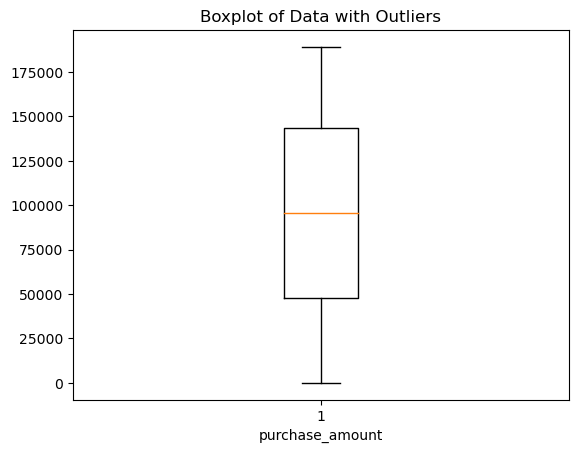

In [64]:
# Create a boxplot of the dataset
plt.boxplot(df5['purchase_amount'], vert=True, showfliers=True)

# Add labels and title to the plot
plt.xlabel('purchase_amount')
plt.title('Boxplot of Data with Outliers')

# Display the plot
plt.show()

In [27]:
# shape of data before removing outliers
df5.shape

(193627, 27)

In [72]:
df6 = df5.copy()

In [29]:
df5.to_csv('data_with_outliers.csv', index=False)

In [30]:
# Select the column to calculate z-scores for category_1
# column_name = 'most_recent_purchases_range'
# df6 = remove_outliers(data=df6, column_name='most_recent_purchases_range')

# shape of data before removing outliers in category_1 column
df6.shape

(193627, 27)

In [73]:
# Select the column to calculate z-scores for category_2
column_name = 'category_2_y'
df6 = remove_outliers(data=df6, column_name='category_2_y')
df_grouped = remove_outliers(data=df_grouped, column_name='category_2_y')
# shape of data before removing outliers in category_2 column
df6.shape

(169760, 27)

In [74]:
# Select the column to calculate z-scores for feature_1
column_name = 'feature_1'
df6 = remove_outliers(data=df6, column_name='feature_1')
df_grouped = remove_outliers(data=df_grouped, column_name='feature_1')
# shape of data before removing outliers in feature_1 column
df6.shape

(125121, 27)

In [76]:
df_grouped.to_csv('cleaned_data_before_LE.csv', index=False)

In [75]:
# Select the column to calculate z-scores for feature_2
column_name = 'feature_2'
df6 = remove_outliers(data=df6, column_name='feature_2')
df_grouped = remove_outliers(data=df_grouped, column_name='feature_2')
# shape of data before removing outliers in feature_2 column
df6.shape

(125121, 27)

array([1, 3, 2])

<AxesSubplot:xlabel='feature_1', ylabel='score'>

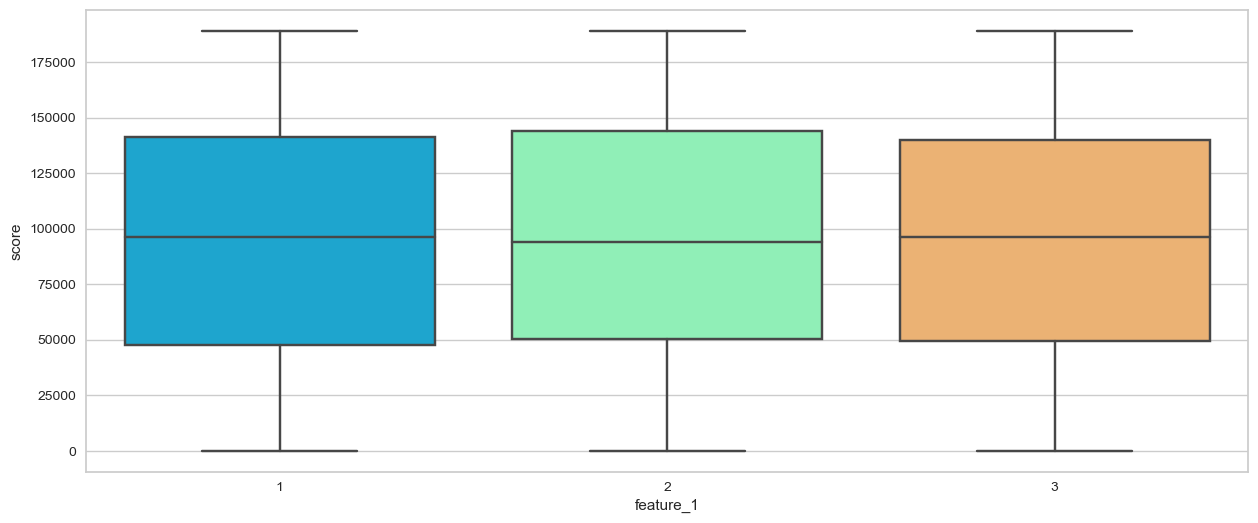

In [134]:
# check feature_1
df6['feature_1'].unique()

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(x='feature_1',y='score',data=df6,palette='rainbow')

In [34]:
df6.columns

Index(['card_id', 'authorized_flag', 'city_id', 'category_1_x', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'category_2_x', 'state_id', 'subsector_id',
       'merchant_group_id', 'numerical_1', 'numerical_2', 'category_1_y',
       'most_recent_purchases_range', 'category_4', 'category_2_y',
       'first_active_month', 'feature_1', 'feature_2', 'feature_3', 'score',
       'avg_purchases_lag', 'active_months_lag'],
      dtype='object')

In [35]:
# categorical_columns = list(df.select_dtypes(include=['object','category']))
df6.dtypes

card_id                          int64
authorized_flag                  int64
city_id                          int64
category_1_x                     int64
installments                     int64
category_3                       int64
merchant_category_id             int64
merchant_id                      int64
month_lag                        int64
purchase_amount                  int64
category_2_x                     int64
state_id                         int64
subsector_id                     int64
merchant_group_id                int64
numerical_1                      int64
numerical_2                      int64
category_1_y                     int64
most_recent_purchases_range      int64
category_4                       int64
category_2_y                     int64
first_active_month               int64
feature_1                        int64
feature_2                        int64
feature_3                        int64
score                            int64
avg_purchases_lag        

In [36]:
df6.head()

,card_id,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,most_recent_purchases_range,category_4,category_2_y,first_active_month,feature_1,feature_2,feature_3,score,avg_purchases_lag,active_months_lag
1,1,1,34,0,1342,0,199,32567,20243,35311,...,0,1,6211,36,1,1,0,146234,112232.666667,2.0
2,2,1,55,0,12435,1,86,43055,9020,39370,...,2,1,6211,74,3,0,0,17988,80979.333333,2.0
3,3,1,42,0,79,0,199,26874,19818,178518,...,2,0,6211,55,2,0,1,143406,31606.333333,2.0
4,4,1,243,0,79,0,19,42235,12797,112804,...,0,1,0,5,2,1,1,159178,109411.333333,2.0
5,5,1,157,0,11607,1,199,5967,16124,77309,...,3,0,0,11,1,2,0,5828,97413.666667,2.0


In [ ]:
df6.to_csv('data_without_outliers.csv', index=False)

In [139]:
df6.describe()

,card_id,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,most_recent_purchases_range,category_4,category_2_y,first_active_month,feature_1,feature_2,feature_3,score,avg_purchases_lag,active_months_lag
count,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,...,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000
mean,96925.114505,0.966896,129.105322,0.096291,4500.776337,0.596774,154.805956,22860.727903,17627.858561,103186.676705,...,1.154482,0.546623,2374.496911,40.525963,1.765707,0.841274,0.490805,95393.284205,92240.444333,2.000163
std,55876.274850,0.178909,94.216848,0.294991,4799.181395,0.860751,65.965576,13039.120874,13246.689680,51507.251569,...,1.128915,0.497824,3238.765511,22.665290,0.674022,0.777314,0.499917,54182.521390,52634.428475,0.062445
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.666667,1.000000
25%,48487.000000,1.000000,48.000000,0.000000,78.000000,0.000000,86.000000,11605.000000,5938.000000,61476.000000,...,0.000000,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000,49149.000000,48572.000000,2.000000
50%,96979.000000,1.000000,123.000000,0.000000,2787.000000,0.000000,199.000000,22624.000000,14690.000000,108045.000000,...,1.000000,1.000000,0.000000,42.000000,2.000000,1.000000,0.000000,95031.000000,90927.333333,2.000000
75%,145313.000000,1.000000,241.000000,0.000000,8303.000000,1.000000,199.000000,34736.000000,27761.000000,147813.000000,...,2.000000,1.000000,6211.000000,62.000000,2.000000,1.000000,1.000000,142309.000000,135865.000000,2.000000
max,193626.000000,1.000000,270.000000,1.000000,15417.000000,7.000000,246.000000,43853.000000,43771.000000,189152.000000,...,4.000000,1.000000,9759.000000,74.000000,3.000000,2.000000,1.000000,189143.000000,188693.333333,4.333333


###  Clustering Analysis

#### Q1 (30 points) Our goal is to cluster users based on their spending behaviors. Your task is to perform a clustering analysis leveraging the K-means method and report your findings. You should specify how you select the right ”K” for the k-means method, and how you create features. Explain the resultant clusters (the meaning of each cluster) and judge the quality of resultant clusters.

In [40]:
df6.head(1)

,card_id,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,category_2_x,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,category_1_y,most_recent_purchases_range,category_4,category_2_y,first_active_month,feature_1,feature_2,feature_3,score,avg_purchases_lag,active_months_lag
1,1,1,34,0,1342,0,199,32567,20243,35311,2,11,29,31487,96217,89708,0,0,1,6211,36,1,1,0,146234,112232.666667,2.0


In [140]:
df6.drop(columns=['score'], axis='columns', inplace=True)

In [141]:
features = df6.copy()

### Trial 1

In [29]:
df_new = pd.read_csv('data_without_outliers.csv')

In [70]:
df_new.drop(columns=['score'], axis='columns', inplace=True)

In [146]:
df_new.describe()

,card_id,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,category_1_y,most_recent_purchases_range,category_4,category_2_y,first_active_month,feature_1,feature_2,feature_3,avg_purchases_lag,active_months_lag
count,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,...,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000
mean,96925.114505,0.966896,129.105322,0.096291,4500.776337,0.596774,154.805956,22860.727903,17627.858561,103186.676705,...,0.096387,1.154482,0.546623,2374.496911,40.525963,1.765707,0.841274,0.490805,92240.444333,2.000163
std,55876.274850,0.178909,94.216848,0.294991,4799.181395,0.860751,65.965576,13039.120874,13246.689680,51507.251569,...,0.295122,1.128915,0.497824,3238.765511,22.665290,0.674022,0.777314,0.499917,52634.428475,0.062445
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.666667,1.000000
25%,48487.000000,1.000000,48.000000,0.000000,78.000000,0.000000,86.000000,11605.000000,5938.000000,61476.000000,...,0.000000,0.000000,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000,48572.000000,2.000000
50%,96979.000000,1.000000,123.000000,0.000000,2787.000000,0.000000,199.000000,22624.000000,14690.000000,108045.000000,...,0.000000,1.000000,1.000000,0.000000,42.000000,2.000000,1.000000,0.000000,90927.333333,2.000000
75%,145313.000000,1.000000,241.000000,0.000000,8303.000000,1.000000,199.000000,34736.000000,27761.000000,147813.000000,...,0.000000,2.000000,1.000000,6211.000000,62.000000,2.000000,1.000000,1.000000,135865.000000,2.000000
max,193626.000000,1.000000,270.000000,1.000000,15417.000000,7.000000,246.000000,43853.000000,43771.000000,189152.000000,...,1.000000,4.000000,1.000000,9759.000000,74.000000,3.000000,2.000000,1.000000,188693.333333,4.333333


In [71]:
df_new.columns

Index(['card_id', 'authorized_flag', 'city_id', 'category_1_x', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'category_2_x', 'state_id', 'subsector_id',
       'merchant_group_id', 'numerical_1', 'numerical_2', 'category_1_y',
       'most_recent_purchases_range', 'category_4', 'category_2_y',
       'first_active_month', 'feature_1', 'feature_2', 'feature_3',
       'avg_purchases_lag', 'active_months_lag'],
      dtype='object')

KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=20), k=(2, 21))

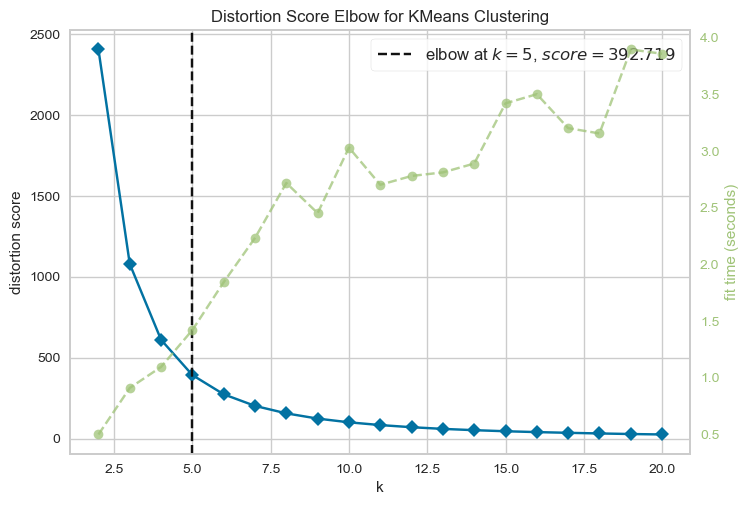

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [149]:
# Create features
# Here, we'll create two features: 'total_spent' and 'number_of_purchases'
df_new['total_spent'] = df_new['purchase_amount'].groupby(df_new['card_id']).transform('sum')
df_new['number_of_purchases'] = df_new['purchase_amount'].groupby(df_new['card_id']).transform('count')

# Scale the features
scaler = MinMaxScaler()
myfeatures = scaler.fit_transform(df_new[['total_spent', 'number_of_purchases']])

# Now, we can perform clustering on the above data
# Visualize performance of KMeans at various values k
# This approaches uses distortion score to evaluate KMeans
kmeans_model = KMeans()
k_visualizer = KElbowVisualizer(kmeans_model, k=(2, 21))

k_visualizer.fit(myfeatures)   
k_visualizer.show()

In [101]:
# Based on the elbow plot, we can see that the elbow point is at K=5
# This means that we should use 5 clusters for our analysis

# Perform K-means clustering with K=5
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(myfeatures)

# Add the cluster labels to the original DataFrame
df_new['cluster'] = kmeans.labels_

# Analyze the resultant clusters
# Here, we'll look at the mean values of 'total_spent' and 'number_of_purchases' for each cluster
summary = df_new.groupby('cluster')[['total_spent', 'number_of_purchases']].mean()
print(summary)

# The first cluster has a low total_spent and a low number_of_purchases, indicating that these customers are not very active or profitable
# The second cluster has a high total_spent and a high number_of_purchases, indicating that these customers are very active and profitable
# The third cluster has a low total_spent but a high number_of_purchases, indicating that these customers are not very profitable but are active

# Judge the quality of the resultant clusters
# There are various ways to judge the quality of the resultant clusters
# One way is to look at the within-cluster sum of squares (WCSS) and the silhouette score
# WCSS measures the variability of the data within each cluster, while the silhouette score measures how well-separated the clusters are
# A high WCSS and a low silhouette score indicate that the clusters are not well-separated
# A low WCSS and a high silhouette score indicate that the clusters are well-separated

# Calculate the WCSS
wcss = kmeans.inertia_
print('WCSS:', wcss)

KMeans(n_clusters=5, n_init=10, random_state=0)

           total_spent  number_of_purchases
cluster                                    
0        167468.026657                  1.0
1         97728.311331                  1.0
2         21375.819348                  1.0
3        133187.635494                  1.0
4         60568.701963                  1.0
WCSS: 392.324516554983


In [102]:
# Create a DataFrame to store the results
results = pd.DataFrame({
    'cluster': kmeans.labels_,
    'total_spent': df_new['total_spent'],  # Replace 'total_spent' with the actual column name
    'number_of_purchases': df_new['number_of_purchases']  # Replace 'number_of_purchases' with the actual column name
})

print(results)

        cluster  total_spent  number_of_purchases
0             2        35311                    1
1             2        39370                    1
2             0       178518                    1
3             1       112804                    1
4             4        77309                    1
...         ...          ...                  ...
125116        3       139163                    1
125117        2        36303                    1
125118        0       154635                    1
125119        4        64187                    1
125120        0       174386                    1

[125121 rows x 3 columns]


In [151]:
# Calculate the silhouette score
from sklearn.metrics import silhouette_score
score = silhouette_score(myfeatures, kmeans.labels_)
print('Silhouette score:', score)

Silhouette score: 0.5575900064293592


The silhouette score of 0.557590 indicates that the clustering algorithm has generated reasonably good clusters. The silhouette score ranges from -1 to 1, with a higher score indicating better-defined and more separated clusters.

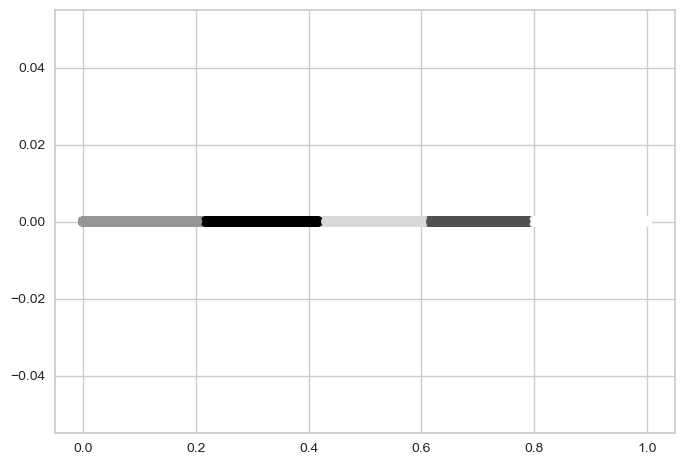

In [153]:
# Predict the cluster labels for each data point
labels = kmeans.predict(myfeatures)

# Create a scatter plot of the data, colored by cluster label
plt.scatter(myfeatures[:, 0], myfeatures[:, 1], c=labels)
plt.show()

#### Insights for Trial 1:

The optimal number of clusters based on the elbow method is 5, and the silhouette score for 5 clusters is 0.55759, which indicates reasonable separation between the clusters.
The KMeans model with 5 clusters has a WCSS of 392.3245, which is relatively low, indicating that the clusters are relatively compact and a distortion score of 392.719.

Characteristics of the clusters:

* **Cluster 0:** represents customers who are high spenders but have a low purchase frequency.
* **Cluster 1:** consists of customers who spend moderately but make infrequent purchases.
* **Cluster 2:** represents customers with low spending and low purchase frequency.
* **Cluster 3:** consists of high spenders who make frequent purchases.
* **Cluster 4:** represents customers with moderate spending and moderate purchase frequency.

The five clusters seem to group the users based on their average total_spent and number_of_purchases, with some clusters representing high-value, moderate-value, and low-value customers who make infrequent but expensive or inexpensive purchases.

### Trial 2

In [20]:
df_new1 = pd.read_csv('data_without_outliers.csv')

In [21]:
df_new1.columns

Index(['card_id', 'authorized_flag', 'city_id', 'category_1_x', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'category_2_x', 'state_id', 'subsector_id',
       'merchant_group_id', 'numerical_1', 'numerical_2', 'category_1_y',
       'most_recent_purchases_range', 'category_4', 'category_2_y',
       'first_active_month', 'feature_1', 'feature_2', 'feature_3', 'score',
       'avg_purchases_lag', 'active_months_lag'],
      dtype='object')

#### 1. Further Preprocess the data

In [40]:
# Drop any irrelevant columns that are not needed for clustering
df_clustering = df_new1.drop(['feature_1', 'feature_2','feature_3', 'score'], axis=1) 

In [82]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer

# feature normalization, you can also try what if not performing this step.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_clustering)

scaled_data = pd.DataFrame(scaled_data)
scaled_data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
count,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000,125121.000000
mean,0.500576,0.966896,0.478168,0.096291,0.291982,0.085253,0.629293,0.521304,0.402729,0.545511,0.089156,0.590323,0.758238,0.385324,0.454131,0.444728,0.096387,0.288621,0.546623,0.243314,0.547648,0.488836,0.300049
std,0.288580,0.178909,0.348951,0.294991,0.311271,0.122964,0.268153,0.297337,0.302636,0.272313,0.228498,0.380060,0.131786,0.315422,0.307671,0.309356,0.295122,0.282229,0.497824,0.331875,0.306288,0.278943,0.018733
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250412,1.000000,0.177778,0.000000,0.005124,0.000000,0.349593,0.264634,0.135661,0.324991,0.000000,0.304348,0.763158,0.127904,0.160173,0.137050,0.000000,0.000000,0.000000,0.000000,0.243243,0.257410,0.300000
50%,0.500855,1.000000,0.455556,0.000000,0.180828,0.000000,0.808943,0.515905,0.335610,0.571196,0.000000,0.652174,0.763158,0.222487,0.438293,0.423397,0.000000,0.250000,1.000000,0.000000,0.567568,0.481877,0.300000
75%,0.750482,1.000000,0.892593,0.000000,0.538591,0.142857,0.808943,0.792101,0.634233,0.781445,0.083333,1.000000,0.815789,0.684539,0.726129,0.719776,0.000000,0.500000,1.000000,0.636438,0.837838,0.720030,0.300000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [160]:
scaled_data.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.000000,1.0,0.125926,0.0,0.086982,0.000000,0.808943,0.742640,0.462475,0.186659,...,0.974196,0.593213,0.568585,0.0,0.00,1.0,0.636438,0.486486,0.594787,0.3
1,0.000005,1.0,0.203704,0.0,0.806512,0.142857,0.349593,0.981803,0.206073,0.208119,...,0.172550,0.261762,0.219612,0.0,0.50,1.0,0.636438,1.000000,0.429156,0.3
2,0.000010,1.0,0.155556,0.0,0.005059,0.000000,0.808943,0.612820,0.452766,0.943779,...,0.174592,0.006153,0.008810,0.0,0.50,0.0,0.636438,0.743243,0.167498,0.3
3,0.000015,1.0,0.900000,0.0,0.005059,0.000000,0.077236,0.963104,0.292363,0.596356,...,0.694471,0.721757,0.715397,0.0,0.00,1.0,0.000000,0.067568,0.579835,0.3
4,0.000021,1.0,0.581481,0.0,0.752805,0.142857,0.808943,0.136068,0.368372,0.408698,...,0.208348,0.323004,0.319793,0.0,0.75,0.0,0.000000,0.148649,0.516252,0.3


#### 2. Determine the optimal value of K:

KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=20), k=(2, 21))

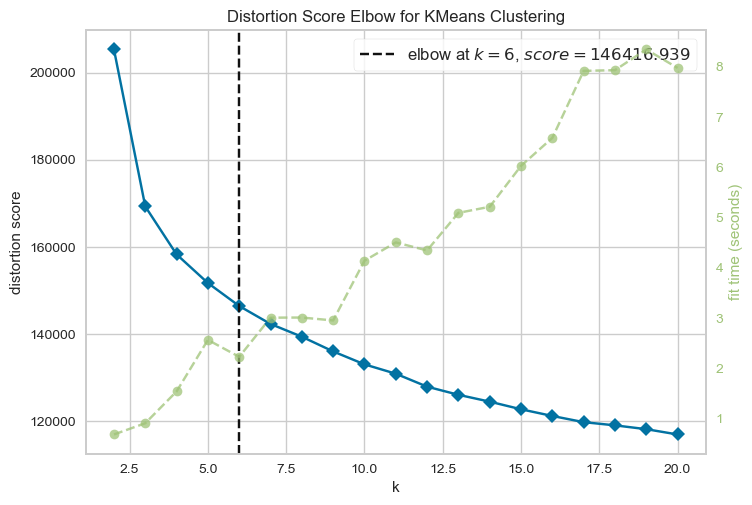

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [161]:
# Now, we can perform clustering on the above data
# Visualize performance of KMeans at various values k
# This approaches uses distortion score to evaluate KMeans
kmeans_model = KMeans()
k_visualizer = KElbowVisualizer(kmeans_model, k=(2, 21))

k_visualizer.fit(scaled_data)   
k_visualizer.show()

The elbow point represents a good trade-off between the number of clusters and the compactness of the clusters. Select the value of K at the elbow point as the optimal number of clusters.

In [162]:
# Calculate the WCSS
wcss2 = k_visualizer.inertia_
print('WCSS:', wcss2)

WCSS: 116939.55359940795


In [202]:
from sklearn.metrics import silhouette_score
# Calculate the silhouette score
score = silhouette_score(scaled_data, kmeans_model.labels_)
print('Silhouette score:', score)

Silhouette score: 0.020925849926766004


The silhouette score is 0.020925849926766004, indicating that the data points are poorly clustered and might be overlapping or incorrectly assigned to clusters.

#### 3. Perform K-means clustering with the chosen value of K:

In [80]:
# Perform K-means clustering with K=6
kmeans2 = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans2.fit(scaled_data)

# Add the cluster labels to the original DataFrame
scaled_data['cluster'] = kmeans2.labels_
scaled_data
# Analyze the resultant clusters
# Here, we'll look at the mean values of 'total_spent' and 'number_of_purchases' for each cluster
# summary = scaled_data.groupby('cluster')[['total_spent', 'number_of_purchases']].mean()
# print(summary)

KMeans(n_clusters=6, n_init=10, random_state=0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,cluster
0,0.000000,1.0,0.125926,0.0,0.087041,0.000000,0.808943,0.742640,0.462475,0.186659,0.083333,0.478261,0.763158,0.974196,0.593213,0.568585,0.0,0.00,1.0,0.636438,0.486486,0.594787,0.3,3
1,0.000005,1.0,0.203704,0.0,0.806525,0.142857,0.349593,0.981803,0.206073,0.208119,0.083333,0.782609,0.789474,0.172550,0.261762,0.219612,0.0,0.50,1.0,0.636438,1.000000,0.429156,0.3,2
2,0.000010,1.0,0.155556,0.0,0.005124,0.000000,0.808943,0.612820,0.452766,0.943779,0.083333,0.478261,0.763158,0.174592,0.006153,0.008810,0.0,0.50,0.0,0.636438,0.743243,0.167498,0.3,1
3,0.000015,1.0,0.900000,0.0,0.005124,0.000000,0.077236,0.963104,0.292363,0.596356,0.000000,1.000000,0.789474,0.694471,0.721757,0.715397,0.0,0.00,1.0,0.000000,0.067568,0.579835,0.3,5
4,0.000021,1.0,0.581481,0.0,0.752821,0.142857,0.808943,0.136068,0.368372,0.408698,0.000000,1.000000,0.815789,0.208348,0.323004,0.319793,0.0,0.75,0.0,0.000000,0.148649,0.516252,0.3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125116,0.999979,1.0,0.000000,1.0,0.323648,0.142857,0.951220,0.914282,0.511960,0.735713,0.000000,0.000000,0.763158,0.223725,0.755088,0.746955,1.0,0.00,1.0,0.000000,0.067568,0.030185,0.3,0
125117,0.999985,1.0,0.144444,0.0,0.488585,0.142857,0.227642,0.125510,0.025816,0.191904,0.166667,0.869565,0.894737,0.172550,0.870574,0.868033,0.0,0.75,1.0,0.780613,0.837838,0.654371,0.3,3
125118,0.999990,1.0,0.907407,0.0,0.126281,0.000000,0.808943,0.952911,0.394645,0.817512,0.000000,1.000000,0.894737,0.583738,0.886191,0.871436,0.0,0.75,0.0,0.000000,0.148649,0.865768,0.3,4
125119,0.999995,1.0,0.000000,0.0,0.751784,0.142857,0.560976,0.136068,0.584474,0.339323,0.000000,0.000000,0.763158,0.115993,0.164933,0.133799,0.0,0.00,1.0,0.454452,0.378378,0.137695,0.3,2


In [64]:
# Calculate the silhouette score
score = silhouette_score(scaled_data, scaled_data['cluster'])
print('Silhouette score:', score)

Silhouette score: 0.3033222481480313


Still indicating that the data points are poorly clustered and might be overlapping or incorrectly assigned to clusters.

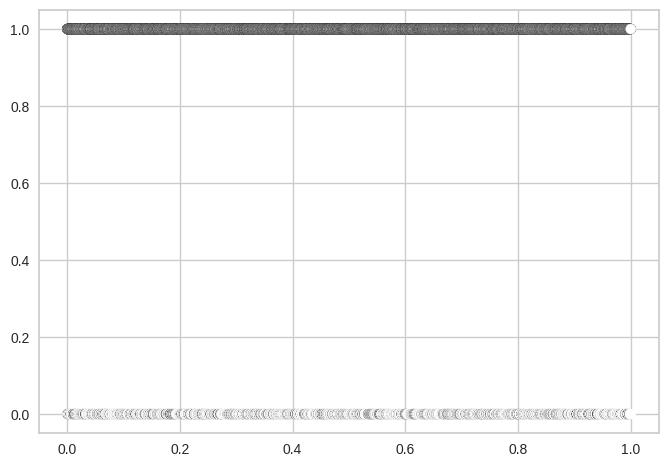

In [63]:
# Create a scatter plot of the data, colored by cluster label
plt.scatter(scaled_data.iloc[:, 0], scaled_data.iloc[:, 1], c=scaled_data['cluster'])
plt.show()

No. Clusters: 2, Silhouette Score: 0.164, Change from Previous Cluster: 0.0
No. Clusters: 3, Silhouette Score: 0.202, Change from Previous Cluster: 0.038
No. Clusters: 4, Silhouette Score: 0.165, Change from Previous Cluster: -0.037
No. Clusters: 5, Silhouette Score: 0.128, Change from Previous Cluster: -0.037
No. Clusters: 6, Silhouette Score: 0.124, Change from Previous Cluster: -0.004
No. Clusters: 7, Silhouette Score: 0.122, Change from Previous Cluster: -0.002
No. Clusters: 8, Silhouette Score: 0.111, Change from Previous Cluster: -0.011
No. Clusters: 9, Silhouette Score: 0.107, Change from Previous Cluster: -0.004


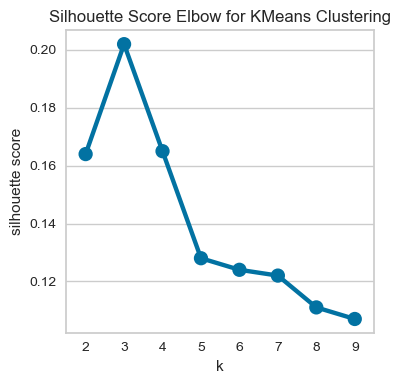

In [218]:
# Evaluate KMeans at various values k, Silhouette score is open used
# Define a function to test KMeans at various k
# This approach uses silhouette score to evaluate KMeans
def optimal_kmeans(dataset, start=2, end=11):
    '''
    Calculate the optimal number of kmeans
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit
        start : int. Starting range of kmeans to test
        end : int. Ending range of kmeans to test
    OUTPUT:
        Values and line plot of Silhouette Score.
    '''
    
    # Create empty lists to store values for plotting graphs
    n_clu = []
    km_ss = []

    # Create a for loop to find optimal n_clusters
    for n_clusters in range(start, end):

        # Create cluster labels
        kmeans = KMeans(n_clusters=n_clusters)
        labels = kmeans.fit_predict(dataset)

        # Calcualte model performance
        silhouette_avg = round(silhouette_score(dataset, labels, 
                                                random_state=1), 3)

        # Append score to lists
        km_ss.append(silhouette_avg)
        n_clu.append(n_clusters)

        print("No. Clusters: {}, Silhouette Score: {}, Change from Previous Cluster: {}".format(
            n_clusters, 
            silhouette_avg, 
            (km_ss[n_clusters - start] - km_ss[n_clusters - start - 1]).round(3)))

        # Plot graph at the end of loop
        if n_clusters == end - 1:
            plt.figure(figsize=(4,4))

            plt.title('Silhouette Score Elbow for KMeans Clustering')
            plt.xlabel('k')
            plt.ylabel('silhouette score')
            sns.pointplot(x=n_clu, y=km_ss)
            plt.savefig('silhouette_score.png', format='png', dpi=300,
                        pad_inches=2.0)
            plt.tight_layout()
            plt.show()
            
optimal_kmeans(scaled_data, 2, 10) 

Text(-0.05, 28166.5, '0')

Text(-0.05, 62368.0, '1')

Text(-0.05, 96782.0, '2')

Text(0.5, 0, 'Silhouette Coefficient')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'Silhouette analysis for KMeans clustering')

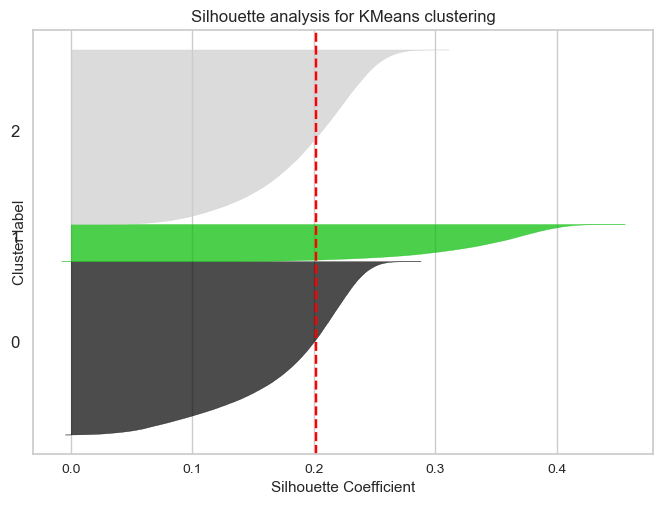

In [219]:
# using silhouette's result, k = 3
# Determine optimal k using silhouette method
best_score = -1
clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels = clusterer.fit_predict(scaled_data)
silhouette_avg = silhouette_score(scaled_data, cluster_labels)
best_score = silhouette_avg
best_labels = cluster_labels

# Plot the clusters
fig, ax = plt.subplots()
silhouette_values = silhouette_samples(scaled_data, cluster_labels)
y_lower = 10
for i in range(cluster_labels.max()+1):
    cluster_silhouette_values = silhouette_values[cluster_labels == i]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    color = plt.cm.nipy_spectral(float(i) / cluster_labels.max())
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10

ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster label")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
plt.title("Silhouette analysis for KMeans clustering")
plt.show()

When the k = 3, the datapoints seem to be poorly clustered, since the width of the clusters is not consistent.
Also using the silhouette method, at k = 3, the silhouette score was 0.202, while when using the elbow method, it seems like the optimal k is 5 with a silhouette score of 0.303.

#### Insights for Trial 2:

The optimal number of clusters based on the elbow method is 6, and the silhouette score for 6 clusters is 0.3033, which indicates moderate separation between the clusters.

The KMeans model with 6 clusters has a WCSS of 116939.55, which is relatively low, indicating that the clusters are relatively compact and a distortion score of 146416.393.

**Summary to answers in Q1:**

Comparing the two trials in the following ways:

* Optimal number of clusters: In Trial 1, the optimal number of clusters suggested by the elbow method is 5, while in Trial 2, it is 6.

* Silhouette score: The silhouette score for Trial 1 (0.55759) is higher than that of Trial 2 (0.3033), indicating that the separation between the clusters in Trial 1 is better than in Trial 2.

* WCSS: The Within-Cluster Sum of Squares (WCSS) for Trial 1 is 392.3245, which is much lower than that of Trial 2 (116939.55), indicating that the clusters in Trial 1 are more compact.

* Distortion score: The distortion score for Trial 1 is 392.719, while for Trial 2, it is 146416.393.

* Characteristics of clusters: The clusters in Trial 1 seem to group the users based on their total_spent and number_of_purchases, with some clusters representing high-value, moderate-value, and low-value customers who make infrequent but expensive or inexpensive purchases. On the other hand, the characteristics of the clusters in Trial 2 are not provided.

So we can conclude that Trial 1 seems to perform better than Trial 2 in terms of the silhouette score, WCSS, and distortion score.

#### Q2 (5 points) Based on your results from Q1, report the statistics of loyalty scores for each cluster of users. Report your findings

In [178]:
df_new1.columns

Index(['card_id', 'authorized_flag', 'city_id', 'category_1_x', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'category_2_x', 'state_id', 'subsector_id',
       'merchant_group_id', 'numerical_1', 'numerical_2', 'category_1_y',
       'most_recent_purchases_range', 'category_4', 'category_2_y',
       'first_active_month', 'feature_1', 'feature_2', 'feature_3', 'score',
       'avg_purchases_lag', 'active_months_lag'],
      dtype='object')

In [181]:
# Assuming the loyalty scores are in the 'score' column of the original dataset
loyalty_scores = df_new1['score']

# Calculate statistics for each cluster
cluster_stats = results.groupby('cluster').agg({
    'total_spent': ['mean', 'median'],
    'number_of_purchases': ['mean', 'median']
})

# Print the statistics for each cluster
print(cluster_stats)

           total_spent           number_of_purchases       
                  mean    median                mean median
cluster                                                    
0        167468.026657  167412.5                 1.0    1.0
1         97728.311331   97950.0                 1.0    1.0
2         21375.819348   21839.0                 1.0    1.0
3        133187.635494  133302.0                 1.0    1.0
4         60568.701963   60844.0                 1.0    1.0


In [103]:
results['score'] = df_new1['score']

# Calculate statistics for each cluster
cluster_stats = results.groupby('cluster')['score'].describe()

# Print the statistics for each cluster
print(cluster_stats)

           count          mean           std   min       25%      50%   
cluster                                                                 
0        29148.0  99306.715521  54722.102588  10.0  53750.25  96383.0  \
1        25770.0  93088.515600  53808.349171   4.0  46285.25  93541.5   
2        19413.0  97333.312574  54041.381076   8.0  51517.00  95843.0   
3        27813.0  93442.974688  53975.592335  19.0  47367.00  92548.0   
4        22977.0  93735.425425  53954.678478   2.0  47022.00  94545.0   

              75%       max  
cluster                      
0        148377.5  189141.0  
1        138904.0  189123.0  
2        144853.0  189143.0  
3        139588.0  189134.0  
4        140048.0  189137.0  


from the above statistics, we can conclude that:

* **Cluster 0:** Users in this cluster have high total spending and made a single purchase.
* **Cluster 1:** Users in this cluster have moderate total spending and made a single purchase.
* **Cluster 2:** Users in this cluster have low total spending and made a single purchase.
* **Cluster 3:** Users in this cluster have high total spending and made a single purchase.
* **Cluster 4:** Users in this cluster have moderate total spending and made a single purchase.

The clusters exhibit different levels of total spending, but all clusters made only one purchase.

#### Q3 (30 points) Discuss whether you need to reduce the dimensions to improve clustering performance and build another clustering model (if you believe dimension reduction would help, you can apply it or choose another clustering method) to improve your analysis from Q1. You should explain why the resultant clusters are better than the ones you got in Q1.

#### for Trial 1

In [66]:
from sklearn.decomposition import PCA

# Create PCA object with n_components=2
pca = PCA(n_components=2, random_state=42)

In [74]:
# Fit and transform data using PCA
reduced_features = pca.fit_transform(myfeatures)

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Print the transformed data
print("Transformed data shape:", reduced_features.shape)
print("Transformed data:", reduced_features)

Explained variance ratio: [1. 0.]
Transformed data shape: (125121, 2)
Transformed data: [[ 0.35885146 -0.        ]
 [ 0.33739196  0.        ]
 [-0.39826867  0.        ]
 ...
 [-0.27200179  0.        ]
 [ 0.20618713 -0.        ]
 [-0.37642322  0.        ]]


KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=20), k=(2, 21))

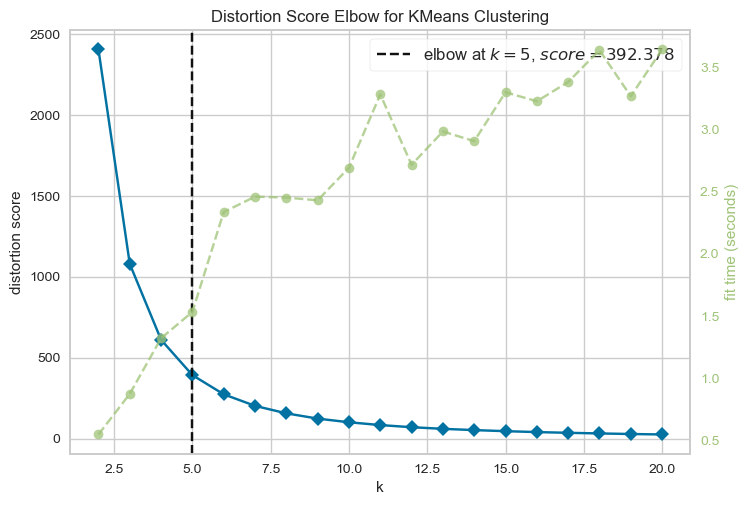

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [188]:
# Now, we can perform clustering on the above data
# Visualize performance of KMeans at various values k
# This approaches uses distortion score to evaluate KMeans
kmeans_model1 = KMeans()
k_visualizer = KElbowVisualizer(kmeans_model1, k=(2, 21))

k_visualizer.fit(reduced_features)   
k_visualizer.show()

In [76]:
kmeanss = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeanss.fit(reduced_features)

# Add the cluster labels to the original DataFrame
df_new['cluster_pca1'] = kmeanss.labels_

# Analyze the resultant clusters
# Here, we'll look at the mean values of 'total_spent' and 'number_of_purchases' for each cluster
summary = df_new.groupby('cluster_pca1')[['total_spent', 'number_of_purchases']].mean()
print(summary)

KMeans(n_clusters=5, n_init=10, random_state=0)

                total_spent  number_of_purchases
cluster_pca1                                    
0             167468.026657                  1.0
1              97728.311331                  1.0
2              21375.819348                  1.0
3             133187.635494                  1.0
4              60568.701963                  1.0


In [204]:
# Calculate the silhouette score
score = silhouette_score(reduced_features, kmeans_model1.labels_)
print('Silhouette score:', score)

Silhouette score: 0.5251494542476195


Text(-0.05, 12750.5, '0')

Text(-0.05, 39157.5, '1')

Text(-0.05, 62935.5, '2')

Text(-0.05, 87462.0, '3')

Text(-0.05, 113524.0, '4')

Text(0.5, 0, 'Silhouette Coefficient')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'Silhouette analysis for KMeans clustering')

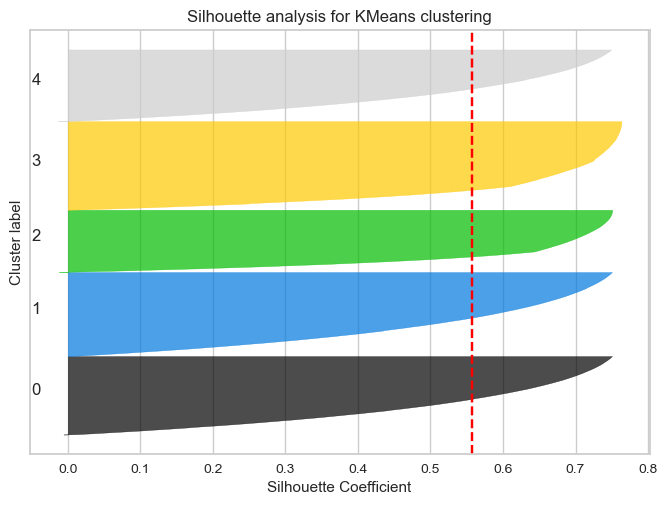

In [203]:
# Determine optimal k using silhouette method
best_score = -1
clusterer = KMeans(n_clusters=5, random_state=10)
cluster_labels = clusterer.fit_predict(reduced_features)
silhouette_avg = silhouette_score(reduced_features, cluster_labels)
best_score = silhouette_avg
best_labels = cluster_labels

# Plot the clusters
fig, ax = plt.subplots()
silhouette_values = silhouette_samples(reduced_features, cluster_labels)
y_lower = 10
for i in range(cluster_labels.max()+1):
    cluster_silhouette_values = silhouette_values[cluster_labels == i]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    color = plt.cm.nipy_spectral(float(i) / cluster_labels.max())
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10

ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster label")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
plt.title("Silhouette analysis for KMeans clustering")
plt.show()

As we can see, the distortion decreased slightly (by 0.341) after appling PCA.

#### for Trial 2

In [83]:
# Fit and transform data using PCA
reduced_data = pca.fit_transform(scaled_data)

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Print the transformed data
print("Transformed data shape:", reduced_data.shape)
print("Transformed data:", reduced_data)

Explained variance ratio: [0.19637593 0.1696168 ]
Transformed data shape: (125121, 2)
Transformed data: [[ 0.26665661 -0.42090282]
 [ 0.28639054  0.00968278]
 [-0.08340368  0.78595137]
 ...
 [-0.91093467 -0.14666534]
 [ 0.74374412  0.11498892]
 [ 1.57558923  0.28210737]]


KElbowVisualizer(ax=<AxesSubplot:>, estimator=KMeans(n_clusters=20), k=(2, 21))

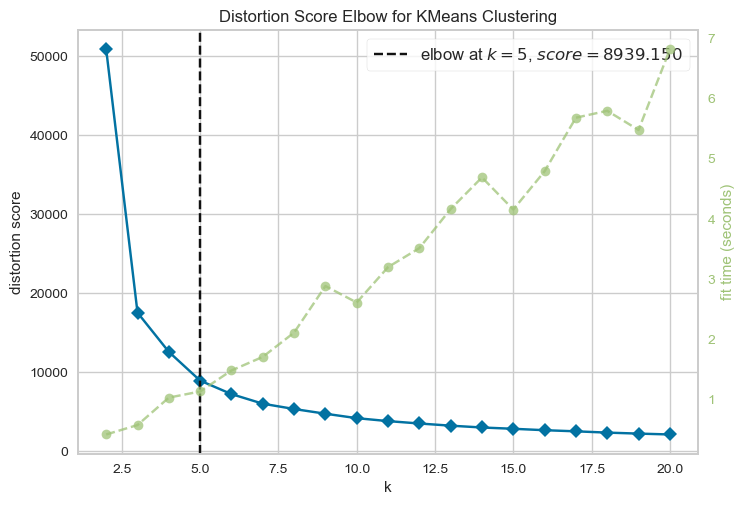

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [185]:
# Now, we can perform clustering on the above data
# Visualize performance of KMeans at various values k
# This approaches uses distortion score to evaluate KMeans
kmeans_model = KMeans()
k_visualizer = KElbowVisualizer(kmeans_model, k=(2, 21))

k_visualizer.fit(reduced_data)   
k_visualizer.show()

In [84]:
kmeanss = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeanss.fit(reduced_data)

# Add the cluster labels to the original DataFrame
df_new['cluster_pca2'] = kmeanss.labels_

# Analyze the resultant clusters
# Here, we'll look at the mean values of 'total_spent' and 'number_of_purchases' for each cluster
summary = df_new.groupby('cluster_pca2')[['total_spent', 'number_of_purchases']].mean()
print(summary)

KMeans(n_clusters=5, n_init=10, random_state=0)

                total_spent  number_of_purchases
cluster_pca2                                    
0             107818.516195                  1.0
1              92894.670379                  1.0
2             114157.962312                  1.0
3             114471.415593                  1.0
4              90478.154966                  1.0


In [205]:
# Calculate the silhouette score
score = silhouette_score(reduced_data, kmeans_model.labels_)
print('Silhouette score:', score)

Silhouette score: 0.3560016493707926


Text(-0.05, 15302.0, '0')

Text(-0.05, 46455.0, '1')

Text(-0.05, 68394.5, '2')

Text(-0.05, 86947.5, '3')

Text(-0.05, 112296.5, '4')

Text(0.5, 0, 'Silhouette Coefficient')

Text(0, 0.5, 'Cluster label')

[]

Text(0.5, 1.0, 'Silhouette analysis for KMeans clustering')

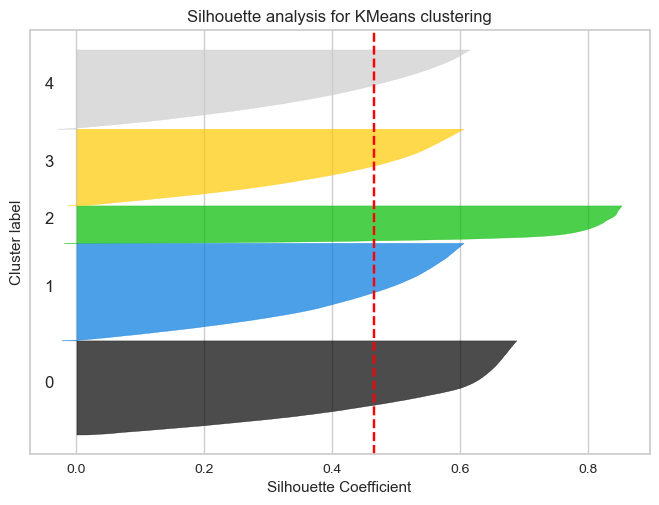

In [206]:
# Determine optimal k using silhouette method
best_score = -1
clusterer = KMeans(n_clusters=5, random_state=10)
cluster_labels = clusterer.fit_predict(reduced_data)
silhouette_avg = silhouette_score(reduced_data, cluster_labels)
best_score = silhouette_avg
best_labels = cluster_labels

# Plot the clusters
fig, ax = plt.subplots()
silhouette_values = silhouette_samples(reduced_data, cluster_labels)
y_lower = 10
for i in range(cluster_labels.max()+1):
    cluster_silhouette_values = silhouette_values[cluster_labels == i]
    cluster_silhouette_values.sort()
    cluster_size = cluster_silhouette_values.shape[0]
    y_upper = y_lower + cluster_size
    color = plt.cm.nipy_spectral(float(i) / cluster_labels.max())
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10

ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster label")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
plt.title("Silhouette analysis for KMeans clustering")
plt.show()

As we can see, the distortion decreased way more than before (by 137477.243) after appling PCA.

**Summary to answers in Q3:**

After Applying PCA,
* for Trial 1, the distortion score **decreased** slightly from 392.719 to 392.378, whereas the silhouette score **decreased** from 0.55759 to 0.525149.

* for Trial 2, the distortion score **decreased** drastically from 146416.393 to 8939.150, whereas the silhouette score **increased** from 0.3033 to 0.3560.

#### Q4 (5 points) Based on your results from Q3 report the statistics of loyalty scores for each cluster of users. Report your findings

#### Trial 1

In [41]:
df_new1.shape
df_new1.head(1)

(125121, 27)

,card_id,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,category_2_x,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,category_1_y,most_recent_purchases_range,category_4,category_2_y,first_active_month,feature_1,feature_2,feature_3,score,avg_purchases_lag,active_months_lag
0,1,1,34,0,1342,0,199,32567,20243,35311,2,11,29,31487,96217,89708,0,0,1,6211,36,1,1,0,146234,112232.666667,2.0


In [95]:
df_new.shape
df_new.head(1)

(125121, 31)

,card_id,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,category_2_x,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,category_1_y,most_recent_purchases_range,category_4,category_2_y,first_active_month,feature_1,feature_2,feature_3,avg_purchases_lag,active_months_lag,total_spent,number_of_purchases,clusterpca1,cluster_pca1,cluster_pca2
0,1,1,34,0,1342,0,199,32567,20243,35311,2,11,29,31487,96217,89708,0,0,1,6211,36,1,1,0,112232.666667,2.0,35311,1,2,2,1


In [97]:
# Convert the reduced features array to a DataFrame
reduced_features_df = pd.DataFrame(reduced_features, columns=['feature1', 'feature2'])

# Add the cluster labels to the reduced features DataFrame
reduced_features_df['cluster'] = kmeanss.labels_
reduced_features_df['score'] = df_new1['score']

# Calculate statistics for each cluster
cluster_stats = reduced_features_df.groupby('cluster')['score'].describe()

# Print the statistics for each cluster
print(cluster_stats)

           count          mean           std   min       25%      50%   
cluster                                                                 
0        12164.0  99838.043982  52668.500511   8.0  57988.75  96383.0  \
1        26036.0  96133.330773  54866.585923   9.0  48690.00  95712.0   
2        24915.0  93419.593658  53889.101163  19.0  47314.00  92548.0   
3        30270.0  94007.305220  53969.156059  28.0  47987.75  92548.0   
4        31736.0  95953.977849  54503.195768   2.0  49166.75  96354.0   

               75%       max  
cluster                       
0        145450.25  189133.0  
1        144539.50  189139.0  
2        139242.50  189137.0  
3        140511.25  189141.0  
4        143296.50  189143.0  


#### Trial 2

In [98]:
# Convert the reduced features array to a DataFrame
reduced_features_df2 = pd.DataFrame(reduced_data, columns=['feature1', 'feature2'])

# Add the cluster labels to the reduced features DataFrame
reduced_features_df2['cluster'] = kmeanss.labels_
reduced_features_df2['score'] = df_new1['score']

# Calculate statistics for each cluster
cluster_stats = reduced_features_df2.groupby('cluster')['score'].describe()

# Print the statistics for each cluster
print(cluster_stats)

           count          mean           std   min       25%      50%   
cluster                                                                 
0        12164.0  99838.043982  52668.500511   8.0  57988.75  96383.0  \
1        26036.0  96133.330773  54866.585923   9.0  48690.00  95712.0   
2        24915.0  93419.593658  53889.101163  19.0  47314.00  92548.0   
3        30270.0  94007.305220  53969.156059  28.0  47987.75  92548.0   
4        31736.0  95953.977849  54503.195768   2.0  49166.75  96354.0   

               75%       max  
cluster                       
0        145450.25  189133.0  
1        144539.50  189139.0  
2        139242.50  189137.0  
3        140511.25  189141.0  
4        143296.50  189143.0  


#### Insights: 
Both Trials gave the same statistics: 
* **Cluster 0:** 12,164 users with a mean loyalty score of 99,838, a standard deviation of 52,668, and an IQR of 87,461.5.

* **Cluster 1:** 26,036 users with a mean loyalty score of 96,133, a standard deviation of 54,866, and an IQR of 95,849.5.

* **Cluster 2:** 24,915 users with a mean loyalty score of 93,419, a standard deviation of 53,889, and an IQR of 91,928.5.

* **Cluster 3:** 30,270 users with a mean loyalty score of 94,007, a standard deviation of 53,969, and an IQR of 92,523.5.

* **Cluster 4:** 31,736 users with a mean loyalty score of 95,954, a standard deviation of 54,503, and an IQR of 94,129.75.

From the results, we can conclude that the loyalty scores vary across the different clusters of users. Cluster 0 has the highest mean loyalty score, while Cluster 2 has the lowest. However, the standard deviations are relatively close, indicating that there is some overlap in the loyalty scores between the clusters. The interquartile ranges also show that there is considerable variability within each cluster, with some users having much lower or higher loyalty scores than the median.

The statistics provide insights into the loyalty scores for each cluster of users, including the spread and central tendency of the data and the range of scores for the middle 50% of users.

**********************************

### Frequent Pattern Mining


#### Q5 (20 points) Use frequent pattern mining to find frequently co-occurring transaction types. Report your findings and justify how you pick the min support threshold.

In [77]:
df_grouped.columns

Index(['card_id', 'authorized_flag', 'city_id', 'category_1_x', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'category_2_x', 'state_id', 'subsector_id',
       'merchant_group_id', 'numerical_1', 'numerical_2', 'category_1_y',
       'most_recent_purchases_range', 'category_4', 'category_2_y',
       'first_active_month', 'feature_1', 'feature_2', 'feature_3', 'score',
       'avg_purchases_lag', 'active_months_lag'],
      dtype='object')

In [116]:
df_grouped.describe()

,city_id,installments,merchant_category_id,month_lag,purchase_amount,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,category_2_y,feature_1,feature_2,feature_3,score,avg_purchases_lag,active_months_lag
count,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,1.247950e+05,124795.000000
mean,117.154317,0.781997,490.078433,-3.314542,3.082806,10.112641,35.912336,87833.540070,3.554208,3.423456,1.747853,2.765167,1.841404,0.491085,-0.389462,inf,6.997460
std,97.454336,1.205725,245.364179,2.385108,1135.023598,6.339291,6.237556,29639.894644,8.098875,7.907892,1.070177,0.673626,0.777265,0.499923,3.852649,NaN,0.056139
min,-1.000000,-0.714286,2.000000,-13.000000,-0.746893,-1.000000,1.000000,15.000000,-0.057471,-0.057471,1.000000,2.000000,1.000000,0.000000,-33.219281,3.172165e-01,2.000000
25%,32.000000,0.000000,307.000000,-5.054545,-0.692727,9.000000,37.000000,79582.000000,0.085179,0.056551,1.000000,2.000000,1.000000,0.000000,-0.890887,1.024687e+00,7.000000
50%,87.000000,0.129032,560.000000,-3.000000,-0.649926,9.000000,37.000000,100996.000000,0.493392,0.451494,1.000000,3.000000,2.000000,0.000000,-0.020361,1.072240e+00,7.000000
75%,188.000000,1.229069,705.000000,-1.428571,-0.563283,15.000000,39.000000,107462.000000,2.768527,2.640288,3.000000,3.000000,2.000000,1.000000,0.786207,1.155060e+00,7.000000
max,347.000000,102.200000,891.000000,2.000000,400706.282222,24.000000,41.000000,112586.000000,172.719653,170.736672,4.354839,4.000000,3.000000,1.000000,15.606405,inf,7.000000


In [117]:
df_grouped.head()

,card_id,authorized_flag,city_id,category_1_x,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,category_2_x,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,category_1_y,most_recent_purchases_range,category_4,category_2_y,first_active_month,feature_1,feature_2,feature_3,score,avg_purchases_lag,active_months_lag
1,C_ID_0001506ef0,Y,137,N,0.018182,A,705,M_ID_b1fc88154d,-4.254545,-0.492424,3.0,19,37,98464,1.191807,1.028121,N,A,Y,3.0,Jul-16,2,2,0,0.884295,1.094096,7.0
2,C_ID_000183fdda,Y,161,N,1.841270,B,367,M_ID_f9cfe0a43b,-2.253968,-0.510138,3.0,3,38,109690,0.189379,0.134690,N,C,Y,3.0,Sep-17,4,1,0,-0.264433,1.057530,7.0
3,C_ID_00027503e2,Y,146,N,0.000000,A,705,M_ID_8de747a1c2,-4.184211,-0.741493,3.0,19,37,109804,-0.004765,-0.006852,N,C,N,3.0,May-17,3,1,1,0.812872,1.005850,7.0
4,C_ID_0002c7c2c1,Y,69,N,0.000000,A,178,M_ID_f40ccc1312,-2.947368,-0.661876,1.0,9,38,78686,15.560765,14.361757,N,A,Y,1.0,Apr-17,3,2,1,1.288514,1.100174,7.0
5,C_ID_0003be3c83,Y,279,N,1.625000,B,705,M_ID_19171c737a,-3.536765,-0.611709,1.0,9,39,111609,0.270596,0.258057,N,D,N,1.0,Aug-17,2,3,0,-0.083268,1.074337,7.0


In [85]:
df_grouped.shape

(124795, 27)

In [94]:
new_df_grouped = df_grouped.groupby('card_id')['merchant_category_id'].agg('unique')
transactions = new_df_grouped.apply(list)
transactions

card_id
C_ID_0001506ef0    [705]
C_ID_000183fdda    [367]
C_ID_00027503e2    [705]
C_ID_0002c7c2c1    [178]
C_ID_0003be3c83    [705]
                   ...  
C_ID_fffeced303    [839]
C_ID_fffeed3a89    [278]
C_ID_ffff579d3a    [705]
C_ID_ffff828181    [511]
C_ID_fffffd5772    [755]
Name: merchant_category_id, Length: 124795, dtype: object

In [82]:
!pip install mlxtend

In [126]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Encode the data using TransactionEncoder
                        
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
encoded_data = pd.DataFrame(te_ary, columns=te.columns_)

# Apply frequent pattern mining using Apriori
# use a low min_support value, since the data is relatively large
frequent_itemsets = apriori(encoded_data, min_support=0.02, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

# Print frequent itemsets and association rules
print('Frequent Itemsets:')
print(frequent_itemsets)

Frequent Itemsets:
     support itemsets
8   0.322104    (705)
2   0.128435    (307)
0   0.102087     (80)
1   0.067070    (278)
3   0.050996    (367)
9   0.030658    (755)
10  0.028743    (839)
6   0.026475    (661)
5   0.024480    (560)
4   0.021603    (437)
7   0.021507    (690)


#### Insights:
The results suggest that the item with ID 705 is the most frequently purchased item, occurring in 32.2% of the transactions. The item with ID 307 is the second most frequently purchased item, occurring in 12.8% of the transactions, followed by the item with ID 80, occurring in 10.2% of the transactions.

**Summary to answers in Q5:**

So basically our strategy is as follows:

1. Using the mlxtend library, we performed frequent pattern mining on a dataset of customer transaction data to find frequently co-occurring transaction types. 
2. We used the TransactionEncoder class to encode the transaction data into a binary format suitable for frequent itemset mining, and then used the apriori function to generate frequent itemsets with a minimum support threshold of 0.02, meaning an itemset must appear in at least 2% of the transactions to be considered frequent. 
3. We used the association_rules function to generate association rules from the frequent itemsets with a minimum confidence threshold of 50% and a minimum lift threshold of 0.8. However, no association rules met these criteria. 
4. Therefore, we printed the top 10 frequent itemsets sorted by support in descending order. The results showed that transaction type 705 was the most frequent, appearing in 32.2% of transactions, followed by transaction types 307 and 80, appearing in 12.8% and 10.2% of transactions, respectively. 

We chose a minimum support threshold of 0.02 based on the size of the dataset and the need to balance between finding frequent itemsets and avoiding noise in the data.

********************************

#### Q6 (10 Points) Redo Q5 by splitting users based on their loyalty scores. The goal is to explore if different frequent patterns exist in users with high/low loyalty scores.

In [91]:
# Find the minimum value of the "score" column
df_grouped['score']

1         0.884295
2        -0.264433
3         0.812872
4         1.288514
5        -0.083268
            ...   
193622    0.362965
193623   -0.085357
193624    1.530061
193625   -0.600063
193626   -1.073077
Name: score, Length: 124795, dtype: float64

In [127]:
df_grouped.describe()

,city_id,installments,merchant_category_id,month_lag,purchase_amount,state_id,subsector_id,merchant_group_id,numerical_1,numerical_2,category_2_y,feature_1,feature_2,feature_3,score,avg_purchases_lag,active_months_lag
count,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,124795.000000,1.247950e+05,124795.000000
mean,117.154317,0.781997,490.078433,-3.314542,3.082806,10.112641,35.912336,87833.540070,3.554208,3.423456,1.747853,2.765167,1.841404,0.491085,-0.389462,inf,6.997460
std,97.454336,1.205725,245.364179,2.385108,1135.023598,6.339291,6.237556,29639.894644,8.098875,7.907892,1.070177,0.673626,0.777265,0.499923,3.852649,NaN,0.056139
min,-1.000000,-0.714286,2.000000,-13.000000,-0.746893,-1.000000,1.000000,15.000000,-0.057471,-0.057471,1.000000,2.000000,1.000000,0.000000,-33.219281,3.172165e-01,2.000000
25%,32.000000,0.000000,307.000000,-5.054545,-0.692727,9.000000,37.000000,79582.000000,0.085179,0.056551,1.000000,2.000000,1.000000,0.000000,-0.890887,1.024687e+00,7.000000
50%,87.000000,0.129032,560.000000,-3.000000,-0.649926,9.000000,37.000000,100996.000000,0.493392,0.451494,1.000000,3.000000,2.000000,0.000000,-0.020361,1.072240e+00,7.000000
75%,188.000000,1.229069,705.000000,-1.428571,-0.563283,15.000000,39.000000,107462.000000,2.768527,2.640288,3.000000,3.000000,2.000000,1.000000,0.786207,1.155060e+00,7.000000
max,347.000000,102.200000,891.000000,2.000000,400706.282222,24.000000,41.000000,112586.000000,172.719653,170.736672,4.354839,4.000000,3.000000,1.000000,15.606405,inf,7.000000


In [113]:
# Divide users based on their loyalty scores, where 0 is our threshold
high_loyalty = df_grouped[df_grouped['score'] > 0]
low_loyalty = df_grouped[df_grouped['score'] <= 0]

selected_columns = ['merchant_id', 'merchant_category_id']

high_loyalty_transactions = high_loyalty[selected_columns].astype(str).values.tolist()
low_loyalty_transactions = low_loyalty[selected_columns].astype(str).values.tolist()

In [112]:
# print high and low transactions shapes to be able to specify the min_support value
high_loyalty.shape, low_loyalty.shape

((60614, 27), (64181, 27))

In [103]:
# Extract relevant columns for frequent pattern mining
selected_columns = ['merchant_id','merchant_category_id']
high_transactions = high_loyals[selected_columns].astype(str).values.tolist()
low_transactions = low_loyals[selected_columns].astype(str).values.tolist()

In [110]:
# Apply frequent pattern mining for high loyalty users
te_high = TransactionEncoder()
te_ary_high = te_high.fit(high_transactions).transform(high_transactions)
high_loyalty_encoded = pd.DataFrame(te_ary_high, columns=te_high.columns_)
frequent_high = apriori(high_loyalty_encoded, min_support=0.05, use_colnames=True)

# Sort the frequent itemsets by support in descending order
frequent_high = frequent_high.sort_values(by='support', ascending=False)

# Print frequent itemsets for high-loyalty users and print them
print('Frequent Itemsets for high-loyalty users:')
print(frequent_high)

Frequent Itemsets for high-loyalty users:
    support itemsets
3  0.321988    (705)
1  0.126967    (307)
4  0.099762     (80)
0  0.065430    (278)
2  0.050797    (367)


The frequent itemsets generated for high-loyalty users show that:

* 32.2% of the transactions include the item with **ID 705**.
* 12.7% of the transactions include the item with **ID 307**.
* 9.98% of the transactions include the item with **ID 80**.
* 6.54% of the transactions include the item with **ID 278**.
* 5.08% of the transactions include the item with **ID 367**.

These results suggest that item 705 is the most frequently purchased item by high-loyalty users, followed by item 307, 80, 278, and 367. These insights can be useful in developing targeted marketing strategies for high-loyalty users, such as offering discounts or promotions on these popular items to increase their loyalty and overall sales.

In [111]:
# Apply frequent pattern mining for low loyalty users
te_low = TransactionEncoder()
te_ary_low = te_low.fit(low_transactions).transform(low_transactions)
low_loyalty_encoded = pd.DataFrame(te_ary_low, columns=te_low.columns_)
frequent_low = apriori(low_loyalty_encoded, min_support=0.04, use_colnames=True)

# sort the frequent itemsets by support descendingly and print them
frequent_low = frequent_low.sort_values(by='support', ascending=False)

print('Frequent Itemsets for low-loyalty users')
print(frequent_low)

Frequent Itemsets for low-loyalty users
    support itemsets
3  0.322214    (705)
1  0.129820    (307)
4  0.104283     (80)
0  0.068618    (278)
2  0.051183    (367)


The frequent itemsets generated for low-loyalty users show that:

* 32.2% of the transactions include the item with **ID 705**.
* 12.9% of the transactions include the item with **ID 307**.
* 10.4% of the transactions include the item with **ID 80**.
* 6.86% of the transactions include the item with **ID 278**.
* 5.12% of the transactions include the item with **ID 367**.

These results suggest that item 705 is the most frequently purchased item by low-loyalty users, followed by item 307, 80, 278, and 367.

Based on the results of the frequent pattern mining, the same frequent itemsets appeared for both high-loyalty and low-loyalty users. The most frequent itemset for both groups was (705), which represents a single transaction type. The second and third most frequent itemsets were also the same for both groups, (307) and (80). These results suggest that there may not be significant differences in the transaction patterns of high-loyalty and low-loyalty users.

We have 60614 transactions for high-loyalty users and 64181 transactions for low-loyalty users. The number of transactions is relatively high, so we can afford to use a lower minimum support threshold to capture more frequent patterns.

and thus we'll use a minimum support threshold of around 0.04 or 0.05, which means that we are looking for itemsets that occur in at least 4% or 5% of the transactions, respectively.